## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb; sb.set()
import xlrd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
###
import requests
from datetime import datetime
import pandas_datareader.data as pdr
import yfinance

ModuleNotFoundError: No module named 'pandas'

### Coletando dados


In [4]:
def calculate_rsi(data, window=14):
    # Calcular as variações de preço
    deltas = data['Close'].diff()

    # Separar as variações de preço em positivas e negativas
    gain = deltas.where(deltas > 0, 0)
    loss = -deltas.where(deltas < 0, 0)

    # Calcular as médias móveis
    average_gain = gain.rolling(window=window, min_periods=1).mean()
    average_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calcular o RSI
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


def calculate_rvi(data, window=10):
    close_prices_diff = data['Close'].diff()
    upward_movements = close_prices_diff.where(close_prices_diff > 0, 0).rolling(window=window).mean()
    downward_movements = close_prices_diff.where(close_prices_diff < 0, 0).abs().rolling(window=window).mean()

    # Calcular o RVI
    rvi = (upward_movements / (upward_movements + downward_movements)) * 100

    return rvi


# Fazer a requisição para a API da Binance
requisicao_15m = requests.get("https://api.binance.us/api/v3/klines?symbol=BTCUSDT&interval=15m&limit=1000")
requisicao_1h = requests.get("https://api.binance.us/api/v3/klines?symbol=BTCUSDT&interval=1h&limit=1000")
requisicao_1d = requests.get("https://api.binance.us/api/v3/klines?symbol=BTCUSDT&interval=1d&limit=1000")
requisicao_1w = requests.get("https://api.binance.us/api/v3/klines?symbol=BTCUSDT&interval=1w&limit=1000")

# Verificar se a requisição foi bem-sucedida
def bancoDeDados(time_rec):
    requisicao = requests.get(f"https://api.binance.us/api/v3/klines?symbol=BTCUSDT&interval={time_rec}&limit=1000")
    if requisicao.status_code == 200:
        dados_historicos = requisicao.json()

        # Converter dados em DataFrame
        colunas = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBaseAssetVolume', 'TakerBuyQuoteAssetVolume', 'Ignore']  # Remover esse ignore depois
        dados = pd.DataFrame(dados_historicos, columns=colunas).astype(float)

        # Converter o timestamp para datetime
        dados['Timestamp'] = pd.to_datetime(dados['Timestamp'], unit='ms')

        # Definir o timestamp como índice do DataFrame
        # dados = dados.set_index('Timestamp')
        dados['mm9d'] = dados['Close'].rolling(9).mean()
        dados['mm14d'] = dados['Close'].rolling(14).mean()
        dados['mm21d'] = dados['Close'].rolling(21).mean()
        dados['mm55d'] = dados['Close'].rolling(55).mean()
        dados['mm12d'] = dados['Close'].rolling(12).mean()
        dados['mm26d'] = dados['Close'].rolling(26).mean()
        dados['MACD_linha'] = dados['mm12d'] - dados['mm26d']
        dados['MACD_media'] = dados['MACD_linha'].rolling(9).mean()
        dados['MACD_hist'] = dados['MACD_linha'] - dados['MACD_media']
        # Aplicar a função calculate_rsi aos dados
        dados['RSI'] = calculate_rsi(dados)
        dados['RVI'] = calculate_rvi(dados)
        dados['Close'] = dados['Close'].shift(-1)
        dados.dropna(inplace=True)
        dados = dados.drop(columns='Ignore')
        dados = dados.reset_index(drop=True)
        return dados
    else:
        print(f"Erro ao fazer a requisição: {requisicao.status_code}")

dados_15m = bancoDeDados('5m')
dados_1h = bancoDeDados('1h')
dados_1d = bancoDeDados('1d')
dados_1w = bancoDeDados('1w')

# Exibir os dados com o RSI calculado
display(dados_15m)

NameError: name 'requests' is not defined

In [5]:
yfinance.pdr_override()

init = "2014-10-01"
end = "2024-03-05"

ticker1 = yfinance.Ticker("^GSPC")
ticker2 = yfinance.Ticker("BTC-USD")
ticker1_df = ticker1.history(period='496wk', interval='1wk')
ticker2_df = ticker2.history(period='496wk', interval='1wk')
pd.merge(ticker1_df, ticker2_df, left_index=True, right_index=True)
ticker2_df
# 5m
# 15m -> 60d
# 30m
# 90m
# 1h -> 730d
# 1d -> max
# ticker.get_info()

# dados_yfinance = pdr.get_data_yahoo(ticker, init, end)
# display(dados_yfinance)

NameError: name 'yfinance' is not defined

## Analise tecnica 1h

In [ ]:
dados = bancoDeDados('3d')

def selectAnaliseTec(dados):
    qtd_data = len(dados)
    train_size = int(0.7 * qtd_data)
    test_size = int(0.25 * qtd_data)
    val_size = qtd_data - train_size - test_size

    #separando as features e labels
    features = dados.drop(['CloseTime', 'Close', 'Timestamp'], axis=1)  # Ver isso mais tarde
    labels = dados['Close']

    return qtd_data, train_size, test_size, val_size, features, labels

qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(dados)

,Timestamp,Open,High,Low,Close,Volume,CloseTime,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,...,mm14d,mm21d,mm55d,mm12d,mm26d,MACD_linha,MACD_media,MACD_hist,RSI,RVI
0,2020-03-02,8525.48,8963.39,8502.03,8886.71,244.947742,1.583366e+12,2.149440e+06,7834.0,108.939390,...,9437.737857,9050.869524,8388.558182,9533.617500,8706.386923,827.230577,978.248056,-151.017479,50.776413,42.282388
1,2020-03-05,8765.21,9199.13,8765.21,7888.99,234.855009,1.583626e+12,2.121066e+06,7905.0,101.494367,...,9476.447143,9124.072381,8395.231636,9494.761667,8771.980000,722.781667,959.912073,-237.130406,55.612796,36.435277
2,2020-03-08,8885.47,8885.47,7642.21,5582.50,578.999314,1.583885e+12,4.643125e+06,8251.0,311.317522,...,9369.936429,9110.484286,8389.963636,9377.194167,8793.808077,583.386090,919.618504,-336.232415,34.434727,20.635542
3,2020-03-11,7880.00,7977.46,3649.04,5023.00,4595.778669,1.584144e+12,2.515898e+07,32939.0,2689.237530,...,9100.616429,8986.079524,8340.693636,9028.486667,8731.276154,297.210513,840.988832,-543.778319,23.332089,10.059394
4,2020-03-14,5583.79,5943.59,4426.37,6179.03,1016.109747,1.584403e+12,5.246939e+06,6402.0,593.019682,...,8795.130714,8839.447619,8282.526545,8600.942500,8640.196538,-39.254038,718.165598,-757.419637,21.772682,9.878152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,2024-02-22,51865.96,52018.79,50551.87,57067.00,140.410680,1.708819e+12,7.201765e+06,14492.0,74.954640,...,45678.134286,45030.025238,38329.894545,46222.864167,44563.246154,1659.618013,830.184395,829.433618,75.719672,95.628811
485,2024-02-25,51562.27,57500.00,50930.04,62394.58,364.637430,1.709078e+12,1.992427e+07,44076.0,236.843460,...,46673.962143,45722.436190,38883.773455,47682.305000,45172.076538,2510.228462,988.952066,1521.276396,81.400953,96.543304
486,2024-02-28,57067.00,63583.26,56719.85,68152.44,645.650870,1.709338e+12,3.935421e+07,82819.0,366.918090,...,48152.567857,46689.539048,39531.746182,49554.272500,45916.793846,3637.478654,1292.117977,2345.360677,89.662809,97.335297
487,2024-03-02,62412.48,68309.21,61365.23,66845.27,311.684160,1.709597e+12,2.001905e+07,55405.0,183.987490,...,50195.334286,47839.655714,40287.855273,51728.389167,46946.948077,4781.441090,1755.051182,3026.389907,98.124864,97.880846


In [ ]:
#Escolhendo as melhores features com Kbest

features_list = ('Open','High','Low','NumberOfTrades', 'QuoteAssetVolume', 'TakerBuyBaseAssetVolume', 'TakerBuyQuoteAssetVolume','Volume','mm9d', 'mm14d','mm21d', 'mm55d')  # Falta adicionar coisa

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'mm55d': nan, 'mm21d': nan, 'mm14d': nan, 'mm9d': nan, 'Volume': nan, 'TakerBuyQuoteAssetVolume': nan, 'TakerBuyBaseAssetVolume': nan, 'QuoteAssetVolume': nan, 'NumberOfTrades': nan, 'Low': nan, 'High': nan}


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


In [ ]:
#separando as features escolhidas
features = dados.loc[:,['High','Low', 'Volume', 'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBaseAssetVolume', 'TakerBuyQuoteAssetVolume', 'mm9d', 'mm14d','mm21d', 'mm55d']]
features

,High,Low,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,mm9d,mm14d,mm21d,mm55d
0,42365.00,42212.31,0.277010,1.172664e+04,191.0,0.242430,1.026405e+04,42204.623333,42128.925000,42124.176190,42065.230909
1,42337.72,42195.70,0.101330,4.283216e+03,96.0,0.015460,6.537575e+02,42199.623333,42146.299286,42118.891429,42071.470000
2,42344.83,42000.00,1.180400,4.969488e+04,245.0,0.221350,9.329111e+03,42173.064444,42167.838571,42112.220952,42078.554545
3,42139.57,41958.82,0.623910,2.621735e+04,231.0,0.103560,4.355201e+03,42150.425556,42164.341429,42097.604762,42084.420727
4,42112.26,41843.97,3.477370,1.457832e+05,313.0,0.248090,1.043057e+04,42129.341111,42163.479286,42088.317619,42089.676909
...,...,...,...,...,...,...,...,...,...,...,...
940,68572.29,67598.75,14.737700,1.005245e+06,1779.0,12.128180,8.272956e+05,67538.805556,67363.049286,67331.862857,66875.238182
941,69845.00,67311.48,37.304354,2.556626e+06,4542.0,24.985314,1.714808e+06,67545.647778,67408.856429,67334.299524,66889.886727
942,67909.96,66125.30,28.146710,1.884800e+06,2590.0,14.997760,1.005139e+06,67618.791111,67461.220714,67346.378571,66919.280000
943,68800.00,67636.47,10.683340,7.294236e+05,1404.0,6.704800,4.578743e+05,67757.440000,67554.391429,67389.967619,66951.297091


In [ ]:
#Separa os dados de treino teste e validação
X_train = features[:train_size]
X_test = features[train_size:train_size + test_size -1]

y_train = labels[:train_size]
y_test = labels[train_size:train_size + test_size -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

661 661
235 235


In [ ]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

In [ ]:
# treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred= lr.predict(X_test_scale)
cd =r2_score(y_test, pred)

f'Coeficiente de determinação:{cd * 100:.2f}'

'Coeficiente de determinação:97.65'

In [ ]:
#rede neural
rn = MLPRegressor(max_iter=10000)

rn.fit(X_train_scale, y_train)
pred = rn.predict(X_test_scale)

cd = rn.score(X_test_scale, y_test)


f'Coeficiente de determinação:{cd * 100:.2f}'

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


'Coeficiente de determinação:88.49'

In [ ]:
valor_novo = features.tail(1)  # Mudar para pegar o valor da API
valor_novo

,High,Low,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,mm9d,mm14d,mm21d,mm55d
944,68800.0,68111.73,7.10683,486617.456802,720.0,3.87937,265773.52746,67917.764444,67661.13,67457.890952,66975.088182


In [ ]:
#executando a previsão


previsao = scaler.transform(valor_novo)

# Ajustar o modelo com dados de treinamento
#rn.fit(X_train_scale, y_train)

# Fazer previsões com o modelo ajustado
# pred2 = rn.predict(previsao)

# Corrigindo o aviso de depreciação
# Supondo que 'previsao1' seja um array com um único elemento
pred1 = float(lr.predict(previsao)[0])

# Se 'previsao' for um array com múltiplos elementos, você precisa especificar qual elemento deseja
# Por exemplo, para o primeiro elemento:
#pred2 = float(rn.predict(previsao)[0])


print(f'Prev1: {pred1:.2f}')
#\nPrev2: {pred2:.2f}')

Prev1: 68397.42


### Teste

In [ ]:
# Teste
test = train_size + test_size
previsao = scaler.transform(features[test:qtd_data])

data_final_full = dados['Timestamp']
data_final = data_final_full[test:qtd_data]

real_full = dados['Close']
real = real_full[test:qtd_data]

pred_lr = lr.predict(previsao)

df_final = pd.DataFrame({'Timestamp': data_final, 'real': real, 'Previsao': pred_lr})
df_final['real'] = df_final['real'].shift(+1)
df_final.set_index('Timestamp', inplace=True)
df_final = df_final.dropna()

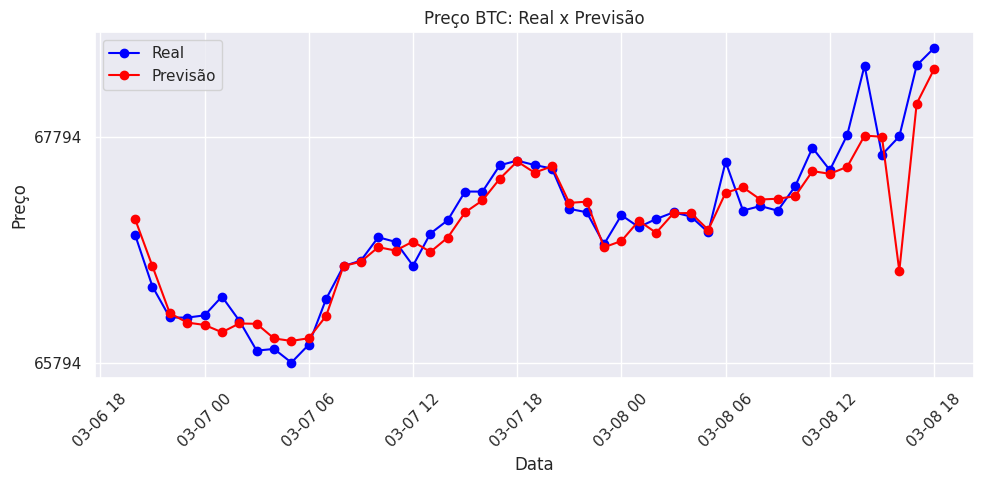

In [ ]:
import matplotlib.pyplot as plt

# Convertendo os valores em listas
timestamps = df_final.index.tolist()
real_values = df_final['real'].astype(int).tolist()
predicted_values = df_final['Previsao'].astype(int).tolist()

# Plot dos valores
plt.figure(figsize=(10, 5))
plt.plot(timestamps, real_values, label='Real', color='blue', marker='o')
plt.plot(timestamps, predicted_values, label='Previsão', color='red', marker='o')

# Adiciona rótulos e legendas
plt.title('Preço BTC: Real x Previsão')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Define os valores exatos no eixo y
plt.yticks(range(min(real_values), max(real_values) + 1, 2000))

plt.tight_layout()

# Mostra o gráfico
plt.show()

## Analise tecnica 1d

## Analise Tecnica 1w

## Trade

## Previsão dos proximos 20 valores com intervalo de 5 minutos
- Modelo de Regressão Linear
- Fazer 3 modelos,1 para o close (Já feito), um pro maximo e 1 pro minimo
- Ultimo dado deve ser prenchido com uma 21° previsão

In [ ]:
def calculate_rsi(data, window=14):
    # Calcular as variações de preço
    deltas = data['Close'].diff()

    # Separar as variações de preço em positivas e negativas
    gain = deltas.where(deltas > 0, 0)
    loss = -deltas.where(deltas < 0, 0)

    # Calcular as médias móveis
    average_gain = gain.rolling(window=window, min_periods=1).mean()
    average_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calcular o RSI
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


def calculate_rvi(data, window=10):
    close_prices_diff = data['Close'].diff()
    upward_movements = close_prices_diff.where(close_prices_diff > 0, 0).rolling(window=window).mean()
    downward_movements = close_prices_diff.where(close_prices_diff < 0, 0).abs().rolling(window=window).mean()

    # Calcular o RVI
    rvi = (upward_movements / (upward_movements + downward_movements)) * 100

    return rvi


# Treinando modelos
def bancoDeDados(time_rec):
    requisicao = requests.get(f"https://api.binance.us/api/v3/klines?symbol=BTCUSDT&interval={time_rec}&limit=1000")
    if requisicao.status_code == 200:
        dados_historicos = requisicao.json()

        # Converter dados em DataFrame
        colunas = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBaseAssetVolume', 'TakerBuyQuoteAssetVolume', 'Ignore']  # Remover esse ignore depois
        dados = pd.DataFrame(dados_historicos, columns=colunas).astype(float)

        # Converter o timestamp para datetime
        dados['Timestamp'] = pd.to_datetime(dados['Timestamp'], unit='ms')

        # Definir o timestamp como índice do DataFrame
        # dados = dados.set_index('Timestamp')
        dados['mm9d'] = dados['Close'].rolling(9).mean()
        dados['mm14d'] = dados['Close'].rolling(14).mean()
        dados['mm21d'] = dados['Close'].rolling(21).mean()
        dados['mm55d'] = dados['Close'].rolling(55).mean()
        dados['mm12d'] = dados['Close'].rolling(12).mean()
        dados['mm26d'] = dados['Close'].rolling(26).mean()
        dados['MACD_linha'] = dados['mm12d'] - dados['mm26d']
        dados['MACD_media'] = dados['MACD_linha'].rolling(9).mean()
        dados['MACD_hist'] = dados['MACD_linha'] - dados['MACD_media']
        dados['RSI'] = calculate_rsi(dados)
        dados['RVI'] = calculate_rvi(dados)
        dados['Close'] = dados['Close'].shift(-1)
        dados.dropna(inplace=True)
        dados = dados.drop(columns='Ignore')
        dados = dados.reset_index(drop=True)
        return dados
    else:
        print(f"Erro ao fazer a requisição: {requisicao.status_code}")


def trainModelLinear(tempo):
    dados = bancoDeDados(f'{tempo}')  # DEPOIS FAZER UM YFINANCE

    def selectAnaliseTec(dados):
        qtd_data = len(dados)
        train_size = int(0.65 * qtd_data)
        test_size = int(0.35 * qtd_data)
        val_size = qtd_data - train_size - test_size

        #separando as features e labels
        features = dados.drop(['CloseTime', 'Close', 'Timestamp'], axis=1)  # Ver isso mais tarde
        labels = dados['Close']

        return qtd_data, train_size, test_size, val_size, features, labels

    qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(dados)

    #separando as features escolhidas
    features = dados.loc[:,['High','Low', 'Volume', 'QuoteAssetVolume',
                            'NumberOfTrades', 'TakerBuyBaseAssetVolume',
                            'TakerBuyQuoteAssetVolume', 'mm9d', 'mm14d',
                            'mm21d', 'mm55d', 'mm12d', 'mm26d', 'MACD_linha',
                            'MACD_media', 'MACD_hist','RVI', 'RSI']]

    #Separa os dados de treino teste e validação
    X_train = features[:train_size]
    X_test = features[train_size:train_size + test_size -1]

    y_train = labels[:train_size]
    y_test = labels[train_size:train_size + test_size -1]

    # Normalizando os dados de entrada(features)

    # Gerando o novo padrão
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
    X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

    # treinamento usando regressão linear
    lr = linear_model.LinearRegression()
    lr.fit(X_train_scale, y_train)
    pred = lr.predict(X_test_scale)
    cd = r2_score(y_test, pred)

    valor_novo = features.tail(1)
    previsao = scaler.transform(valor_novo)
    pred = lr.predict(previsao)

    return [pred, cd]


def trainModelNeural(tempo):
    dados = bancoDeDados(f'{tempo}')  # DEPOIS FAZER UM YFINANCE
    qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(dados)

    #separando as features escolhidas
    features = dados.loc[:,['High','Low', 'Volume', 'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBaseAssetVolume', 'TakerBuyQuoteAssetVolume', 'mm9d', 'mm14d','mm21d', 'mm55d']]

    #Separa os dados de treino teste e validação
    X_train = features[:train_size]
    X_test = features[train_size:train_size + test_size -1]

    y_train = labels[:train_size]
    y_test = labels[train_size:train_size + test_size -1]

    # Normalizando os dados de entrada(features)

    # Gerando o novo padrão
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
    X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

    #rede neural
    rn = MLPRegressor(max_iter=10000)

    rn.fit(X_train_scale, y_train)
    pred = rn.predict(X_test_scale)

    cd = rn.score(X_test_scale, y_test)


    f'Coeficiente de determinação:{cd * 100:.2f}'

    valor_novo = features.tail(1)
    valor_novo_scale = scaler.transform(valor_novo)
    # Fazer a previsão com o modelo ajustado
    pred = search.predict(valor_novo_scale)

    return [pred, cd]


def trainModelNeuralHyper(tempo):
    dados = bancoDeDados(f'{tempo}')  # DEPOIS FAZER UM YFINANCE
    qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(dados)

    #separando as features escolhidas
    features = dados.loc[:,['High','Low', 'Volume', 'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBaseAssetVolume', 'TakerBuyQuoteAssetVolume', 'mm9d', 'mm14d','mm21d', 'mm55d']]

    #Separa os dados de treino teste e validação
    X_train = features[:train_size]
    X_test = features[train_size:train_size + test_size -1]

    y_train = labels[:train_size]
    y_test = labels[train_size:train_size + test_size -1]

    # Normalizando os dados de entrada(features)

    # Gerando o novo padrão
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
    X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

    #rede neural com ajuste hyper parameters

    rn = MLPRegressor()
    parameter_space = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    search = GridSearchCV(rn, parameter_space, n_jobs=-1, cv=5)

    search.fit(X_train_scale,y_train)
    clf = search.best_estimator_
    pred = search.predict(X_test_scale)
    cd = search.score(X_test_scale, y_test)

    valor_novo = features.tail(1)
    valor_novo_scale = scaler.transform(valor_novo)
    # Fazer a previsão com o modelo ajustado
    pred = search.predict(valor_novo_scale)

    return [pred, cd]

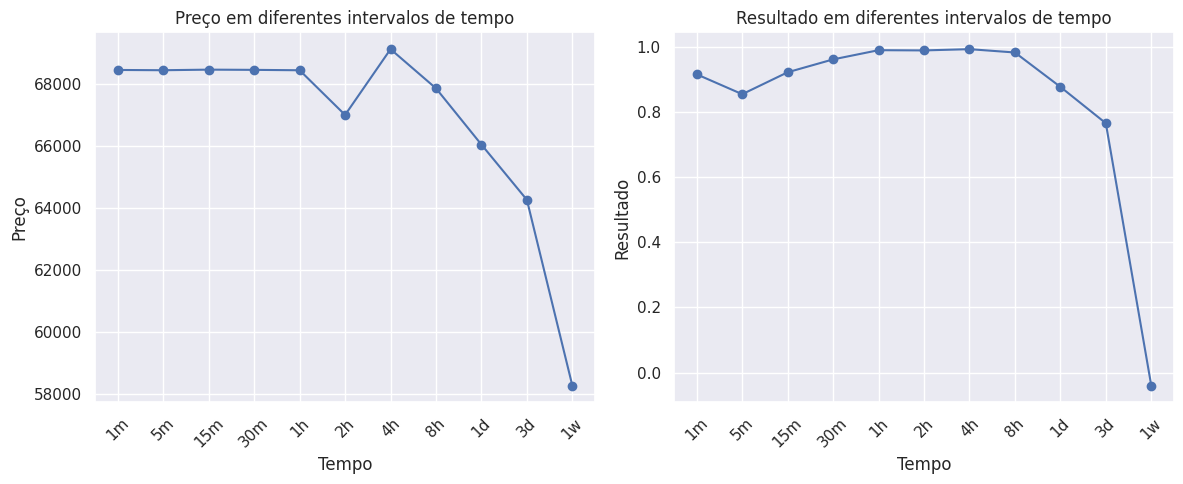

[array([68466.06637573]),
 array([68457.5]),
 array([68476.375]),
 array([68469.25]),
 array([68456.375]),
 array([67012.]),
 array([69138.62500882]),
 array([67872.]),
 array([66052.96361732]),
 array([64267.95221315]),
 array([58262.78668484])]

In [ ]:
"""
1m
5m
15m
30m
1h
2h
4h
8h
"""
tempos = ['1m', '5m', '15m', '30m', '1h', '2h', '4h', '8h', '1d', '3d', '1w']
precos = []
prec_resul = []
for tempo in tempos:
    resul = trainModelLinear(tempo)
    precos.append(resul[0])
    prec_resul.append(resul[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Cria uma figura com dois subplots

# Plot 1: Preços
axs[0].plot(tempos, precos, marker='o', linestyle='-')
axs[0].set_xlabel('Tempo')
axs[0].set_ylabel('Preço')
axs[0].set_title('Preço em diferentes intervalos de tempo')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Plot 2: Resultados
axs[1].plot(tempos, prec_resul, marker='o', linestyle='-')
axs[1].set_xlabel('Tempo')
axs[1].set_ylabel('Resultado')
axs[1].set_title('Resultado em diferentes intervalos de tempo')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()
display(precos)

### Com yfinance

#### Close

17082
Coeficiente de determinação:99.95
Prev_close: 68567.74


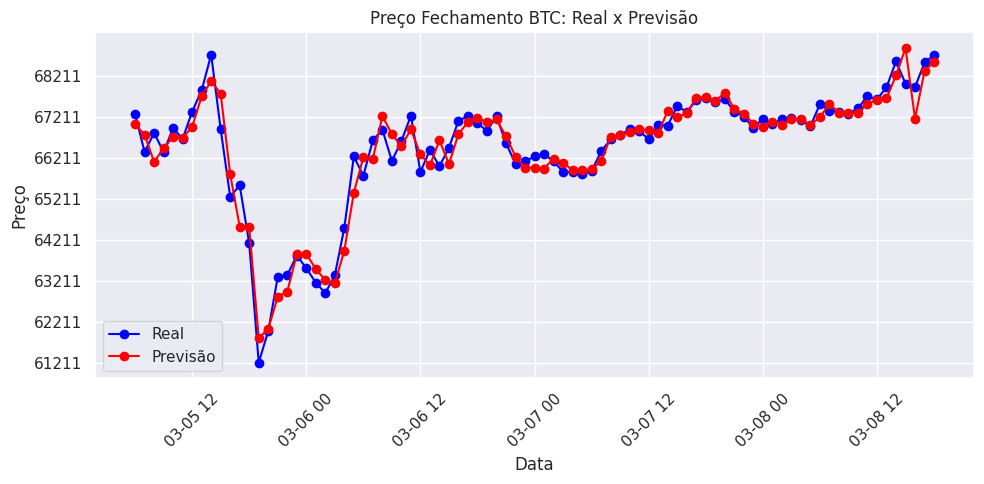

In [ ]:
# 5m -> 60d
# 15m -> 60d
# 30m -> 60d
# 90m -> 60d
# 1h -> 730d
# 1d -> max
ticker = yfinance.Ticker("BTC-USD")
y_dados = ticker.history(period='730d', interval='1h')
y_dados['mm9d'] = y_dados['Close'].rolling(9).mean()
y_dados['mm14d'] = y_dados['Close'].rolling(14).mean()
y_dados['mm21d'] = y_dados['Close'].rolling(21).mean()
y_dados['mm55d'] = y_dados['Close'].rolling(55).mean()
y_dados['mm111d'] = y_dados['Close'].rolling(111).mean()
y_dados['mm350d'] = y_dados['Close'].rolling(350).mean()*2
y_dados['Close'] = y_dados['Close'].shift(-1)
y_dados.dropna(inplace=True)

print(len(y_dados))

def selectAnaliseTec(dados):
    qtd_data = len(dados)
    train_size = int(0.7 * qtd_data)
    test_size = int(0.295 * qtd_data)
    val_size = qtd_data - train_size - test_size

    #separando as features e labels
    features = dados.drop(['Open', 'Close', 'Dividends', 'Stock Splits'], axis=1)
    labels = dados['Close']

    return qtd_data, train_size, test_size, val_size, features, labels

qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(y_dados)

# for tempo in range(5, 66, 5):
#     trainModelLinear(tempo)

features = y_dados.loc[:,['High','Low', 'Volume', 'mm9d', 'mm14d','mm21d', 'mm55d', 'mm111d', 'mm350d']]

#Separa os dados de treino teste e validação
X_train = features[:train_size]
X_test = features[train_size:train_size + test_size -1]

y_train = labels[:train_size]
y_test = labels[train_size:train_size + test_size -1]

# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

# treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred = lr.predict(X_test_scale)
cd_close = r2_score(y_test, pred)

print(f'Coeficiente de determinação:{cd_close * 100:.2f}')

valor_novo = features.tail(1)  # Mudar para pegar o valor da API

#executando a previsão

previsao = scaler.transform(valor_novo)

pred_close = float(lr.predict(previsao)[0])

print(f'Prev_close: {pred_close:.2f}')

# Teste
test = train_size + test_size
previsao = scaler.transform(features[test:qtd_data])

data_final_full = y_dados.index
data_final = data_final_full[test:qtd_data]

real_full = y_dados['Close']
real = real_full[test:qtd_data]

pred_lr = lr.predict(previsao)

df_final = pd.DataFrame({'Datetime': data_final, 'real': real, 'Previsao': pred_lr})
df_final['real'] = df_final['real'].shift(+1)
df_final.set_index('Datetime', inplace=True)
df_final = df_final.dropna()

import matplotlib.pyplot as plt

# Convertendo os valores em listas
timestamps = df_final.index.tolist()
real_values = df_final['real'].astype(int).tolist()
predicted_values = df_final['Previsao'].astype(int).tolist()

# Plot dos valores
plt.figure(figsize=(10, 5))
plt.plot(timestamps, real_values, label='Real', color='blue', marker='o')
plt.plot(timestamps, predicted_values, label='Previsão', color='red', marker='o')

# Adiciona rótulos e legendas
plt.title('Preço Fechamento BTC: Real x Previsão')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Define os valores exatos no eixo y
plt.yticks(range(min(real_values), max(real_values) + 1, 1000))

plt.tight_layout()

# Mostra o gráfico
plt.show()

#### High

17377
Coeficiente de determinação:99.97
Prev_max: 68634.10


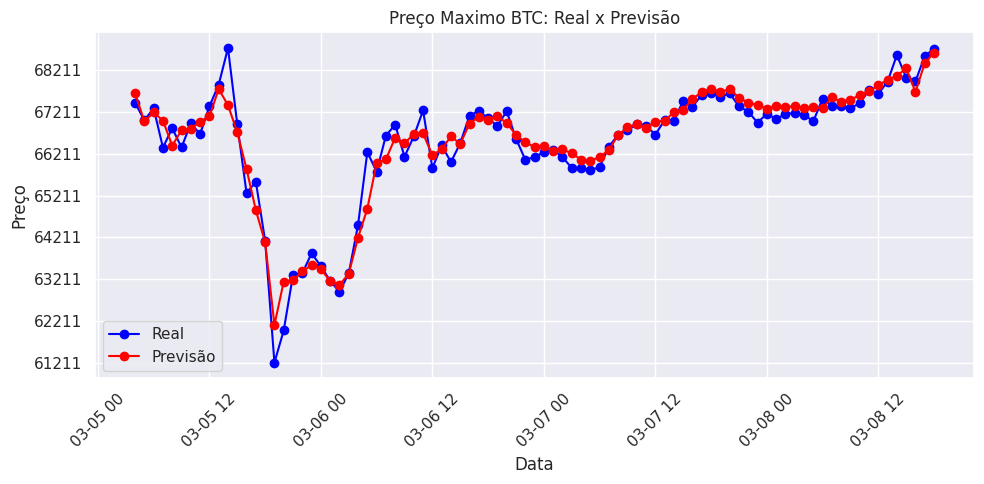

In [ ]:
# 5m -> 60d
# 15m -> 60d
# 30m -> 60d
# 90m -> 60d
# 1h -> 730d
# 1d -> max
ticker = yfinance.Ticker("BTC-USD")
y_dados = ticker.history(period='730d', interval='1h')
y_dados['mm9d'] = y_dados['Close'].rolling(9).mean()
y_dados['mm14d'] = y_dados['Close'].rolling(14).mean()
y_dados['mm21d'] = y_dados['Close'].rolling(21).mean()
y_dados['mm55d'] = y_dados['Close'].rolling(55).mean()
y_dados['Close'] = y_dados['Close'].shift(-1)
y_dados.dropna(inplace=True)

print(len(y_dados))

def selectAnaliseTec(dados):
    qtd_data = len(dados)
    train_size = int(0.7 * qtd_data)
    test_size = int(0.295 * qtd_data)
    val_size = qtd_data - train_size - test_size

    #separando as features e labels
    features = dados.drop(['Open', 'High', 'Dividends', 'Stock Splits'], axis=1)
    labels = dados['High']

    return qtd_data, train_size, test_size, val_size, features, labels

qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(y_dados)

# for tempo in range(5, 66, 5):
#     trainModelLinear(tempo)

features = y_dados.loc[:,['Close','Low', 'Volume', 'mm9d', 'mm14d','mm21d', 'mm55d']]

#Separa os dados de treino teste e validação
X_train = features[:train_size]
X_test = features[train_size:train_size + test_size -1]

y_train = labels[:train_size]
y_test = labels[train_size:train_size + test_size -1]

# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

# treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred= lr.predict(X_test_scale)
cd_max =r2_score(y_test, pred)

print(f'Coeficiente de determinação:{cd_max * 100:.2f}')

valor_novo = features.tail(1)  # Mudar para pegar o valor da API

#executando a previsão

previsao = scaler.transform(valor_novo)

pred_max = float(lr.predict(previsao)[0])

print(f'Prev_max: {pred_max:.2f}')

# Teste
test = train_size + test_size
previsao = scaler.transform(features[test:qtd_data])

data_final_full = y_dados.index
data_final = data_final_full[test:qtd_data]

real_full = y_dados['Close']
real = real_full[test:qtd_data]

pred_lr = lr.predict(previsao)

df_final = pd.DataFrame({'Datetime': data_final, 'real': real, 'Previsao': pred_lr})
df_final['real'] = df_final['real'].shift(+1)
df_final.set_index('Datetime', inplace=True)
df_final = df_final.dropna()

import matplotlib.pyplot as plt

# Convertendo os valores em listas
timestamps = df_final.index.tolist()
real_values = df_final['real'].astype(int).tolist()
predicted_values = df_final['Previsao'].astype(int).tolist()

# Plot dos valores
plt.figure(figsize=(10, 5))
plt.plot(timestamps, real_values, label='Real', color='blue', marker='o')
plt.plot(timestamps, predicted_values, label='Previsão', color='red', marker='o')

# Adiciona rótulos e legendas
plt.title('Preço Maximo BTC: Real x Previsão')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Define os valores exatos no eixo y
plt.yticks(range(min(real_values), max(real_values) + 1, 1000))

plt.tight_layout()

# Mostra o gráfico
plt.show()

#### Low

17377
Coeficiente de determinação:99.97
Prev_min: 68393.60


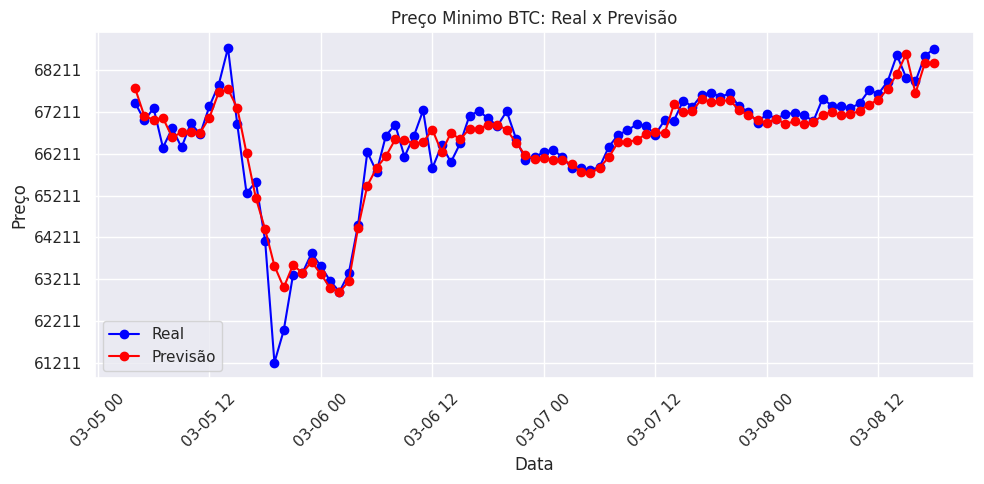

In [ ]:
# 5m -> 60d
# 15m -> 60d
# 30m -> 60d
# 90m -> 60d
# 1h -> 730d
# 1d -> max
ticker = yfinance.Ticker("BTC-USD")
y_dados = ticker.history(period='730d', interval='1h')
y_dados['mm9d'] = y_dados['Close'].rolling(9).mean()
y_dados['mm14d'] = y_dados['Close'].rolling(14).mean()
y_dados['mm21d'] = y_dados['Close'].rolling(21).mean()
y_dados['mm55d'] = y_dados['Close'].rolling(55).mean()
y_dados['Close'] = y_dados['Close'].shift(-1)
y_dados.dropna(inplace=True)

print(len(y_dados))

def selectAnaliseTec(dados):
    qtd_data = len(dados)
    train_size = int(0.7 * qtd_data)
    test_size = int(0.295 * qtd_data)
    val_size = qtd_data - train_size - test_size

    #separando as features e labels
    features = dados.drop(['Open', 'Low', 'Dividends', 'Stock Splits'], axis=1)
    labels = dados['Low']

    return qtd_data, train_size, test_size, val_size, features, labels

qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(y_dados)

# for tempo in range(5, 66, 5):
#     trainModelLinear(tempo)

features = y_dados.loc[:,['High','Close', 'Volume', 'mm9d', 'mm14d','mm21d', 'mm55d']]

#Separa os dados de treino teste e validação
X_train = features[:train_size]
X_test = features[train_size:train_size + test_size -1]

y_train = labels[:train_size]
y_test = labels[train_size:train_size + test_size -1]

# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

# treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred= lr.predict(X_test_scale)
cd_min =r2_score(y_test, pred)

print(f'Coeficiente de determinação:{cd_min * 100:.2f}')

valor_novo = features.tail(1)  # Mudar para pegar o valor da API

#executando a previsão

previsao = scaler.transform(valor_novo)

pred_min = float(lr.predict(previsao)[0])

print(f'Prev_min: {pred_min:.2f}')

# Teste
test = train_size + test_size
previsao = scaler.transform(features[test:qtd_data])

data_final_full = y_dados.index
data_final = data_final_full[test:qtd_data]

real_full = y_dados['Close']
real = real_full[test:qtd_data]

pred_lr = lr.predict(previsao)

df_final = pd.DataFrame({'Datetime': data_final, 'real': real, 'Previsao': pred_lr})
df_final['real'] = df_final['real'].shift(+1)
df_final.set_index('Datetime', inplace=True)
df_final = df_final.dropna()

import matplotlib.pyplot as plt

# Convertendo os valores em listas
timestamps = df_final.index.tolist()
real_values = df_final['real'].astype(int).tolist()
predicted_values = df_final['Previsao'].astype(int).tolist()

# Plot dos valores
plt.figure(figsize=(10, 5))
plt.plot(timestamps, real_values, label='Real', color='blue', marker='o')
plt.plot(timestamps, predicted_values, label='Previsão', color='red', marker='o')

# Adiciona rótulos e legendas
plt.title('Preço Minimo BTC: Real x Previsão')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Define os valores exatos no eixo y
plt.yticks(range(min(real_values), max(real_values) + 1, 1000))

plt.tight_layout()

# Mostra o gráfico
plt.show()

In [ ]:
print(f'                Preço\t\tPresição\n\nMaximo:     US$ {pred_max:.2f}\t{(cd_max * 100):.3f}%\nMinimo:     US$ {pred_min:.2f}\t{(cd_min * 100):.3f}%\nFechamento: US$ {pred_close:.2f}\t{(cd_close * 100):.3f}%')

                Preço		Presição

Maximo:     US$ 68634.10	99.972%
Minimo:     US$ 68393.60	99.972%
Fechamento: US$ 68567.74	99.950%


In [ ]:
#Escolhendo as melhores features com Kbest

features_list = ('High','Low','Volume','mm9d', 'mm14d','mm21d', 'mm55d', 'MACD_linha', 'MACD_media', 'MACD_hist', 'RSI')  # Falta adicionar coisa

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'mm14d': 9092.868048102708, 'mm21d': 6410.935643004624, 'Low': 6050.885379954683, 'mm55d': 5231.694562052819, 'Volume': 4443.836752418778, 'MACD_linha': 1079.13350668961, 'mm9d': 3.6082283095291103}


## Apenas o preço (Recursivo)
- preço (Fechaento, Minimo OU maximo), Primeiro fechamento
- Medias Moveis (9, 14, 21, 55, 111, 350*2
- Usar Preço de abertura para simular Close -1)

Nota: Quando Finalizar Reover dados de validação

In [ ]:
def calculate_rsi(data, window=14):
    # Calcular as variações de preço
    deltas = data['Open'].diff()

    # Separar as variações de preço em positivas e negativas
    gain = deltas.where(deltas > 0, 0)
    loss = -deltas.where(deltas < 0, 0)

    # Calcular as médias móveis
    average_gain = gain.rolling(window=window, min_periods=1).mean()
    average_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calcular o RSI
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


def calculate_rvi(data, window=10):
    close_prices_diff = data['Open'].diff()
    upward_movements = close_prices_diff.where(close_prices_diff > 0, 0).rolling(window=window).mean()
    downward_movements = close_prices_diff.where(close_prices_diff < 0, 0).abs().rolling(window=window).mean()

    # Calcular o RVI
    rvi = (upward_movements / (upward_movements + downward_movements)) * 100

    return rvi

3112
Coeficiente de determinação:97.63


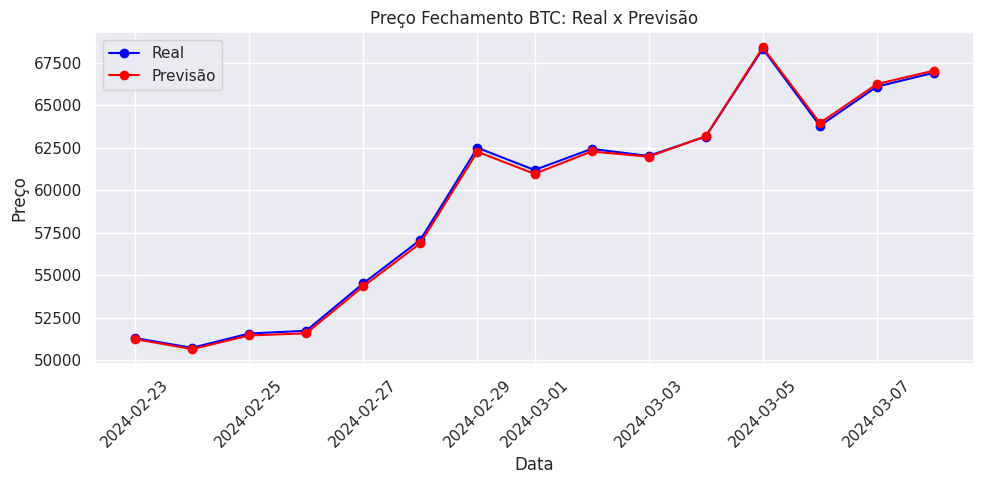

In [ ]:
import yfinance

# 5m -> 60d
# 15m -> 60d
# 30m -> 60d
# 90m -> 60d
# 1h -> 730d
# 1d -> max
ticker = yfinance.Ticker("BTC-USD")
y_dados = ticker.history(period='max', interval='1d')
y_dados['mm9d'] = y_dados['Open'].rolling(9).mean()
y_dados['mm14d'] = y_dados['Open'].rolling(14).mean()
y_dados['mm21d'] = y_dados['Open'].rolling(21).mean()
y_dados['mm55d'] = y_dados['Open'].rolling(55).mean()
y_dados['mm111d'] = y_dados['Open'].rolling(111).mean()
y_dados['mm350d'] = y_dados['Open'].rolling(350).mean()*2
y_dados['mme17d'] = y_dados['Open'].ewm(span=17, adjust=False).mean()
y_dados['mme55d'] = y_dados['Open'].ewm(span=55, adjust=False).mean()
y_dados['mme200d'] = y_dados['Open'].ewm(span=200, adjust=False).mean()
y_dados['mm12d'] = y_dados['Open'].rolling(12).mean()
y_dados['mm26d'] = y_dados['Open'].rolling(26).mean()
y_dados['MACD_linha'] = y_dados['mm12d'] - y_dados['mm26d']
y_dados['MACD_media'] = y_dados['MACD_linha'].rolling(9).mean()
y_dados['MACD_hist'] = y_dados['MACD_linha'] - y_dados['MACD_media']
y_dados['RSI'] = calculate_rsi(y_dados)
y_dados['RVI'] = calculate_rvi(y_dados)
y_dados.dropna(inplace=True)

print(len(y_dados))

def selectAnaliseTec(dados):
    qtd_data = len(dados)
    train_size = int(0.95 * qtd_data)
    test_size = int(0.045 * qtd_data)
    val_size = qtd_data - train_size - test_size

    #separando as features e labels
    features = dados.drop(['Close', 'Dividends', 'Stock Splits', 'Low', 'High', 'Volume'], axis=1)
    labels = dados['Close']

    return qtd_data, train_size, test_size, val_size, features, labels

qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(y_dados)

features = y_dados.loc[:,['Open', 'mm9d', 'mm14d','mm21d', 'mm55d', 'mm111d', 'mm350d', 'mme17d', 'mme55d', 'mme200d', 'mm12d', 'mm26d', 'MACD_linha', 'MACD_media', 'MACD_hist', 'RVI', 'RSI']]

#Separa os dados de treino teste e validação
X_train = features[:train_size]
X_test = features[train_size:train_size + test_size -1]

y_train = labels[:train_size]
y_test = labels[train_size:train_size + test_size -1]

# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

# treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred = lr.predict(X_test_scale)
cd_close = r2_score(y_test, pred)

print(f'Coeficiente de determinação:{cd_close * 100:.2f}')





#executando a previsão


num_prev = 8
prevs = []
for i in range(1, num_prev+1):
    valor_novo = features.tail(1)

    previsao = scaler.transform(valor_novo)

    pred_close = float(lr.predict(previsao)[0])

    new_row = {'Open': pred_close}
    # Cria um novo DataFrame com a nova linha
    new_df = pd.DataFrame([new_row])

    # Concatena o novo DataFrame com o DataFrame existente
    features = pd.concat([features, new_df], ignore_index=True)

    # Calcula as médias móveis para a última linha adicionada
    row_index = features.index[-1]
    features.loc[row_index, 'mm9d'] = features['Open'].iloc[:row_index+1].rolling(9).mean().iat[-1]
    features.loc[row_index, 'mm14d'] = features['Open'].iloc[:row_index+1].rolling(14).mean().iat[-1]
    features.loc[row_index, 'mm21d'] = features['Open'].iloc[:row_index+1].rolling(21).mean().iat[-1]
    features.loc[row_index, 'mm55d'] = features['Open'].iloc[:row_index+1].rolling(55).mean().iat[-1]
    features.loc[row_index, 'mm111d'] = features['Open'].iloc[:row_index+1].rolling(111).mean().iat[-1]
    mm350d = features['Open'].iloc[:row_index+1].rolling(350).mean()
    features.loc[row_index, 'mm350d'] = (mm350d * 2).iat[-1]
    features.loc[row_index, 'mme17d'] = features['Open'].iloc[:row_index+1].ewm(span=17, adjust=False).mean().iat[-1]
    features.loc[row_index, 'mme55d'] = features['Open'].iloc[:row_index+1].ewm(span=55, adjust=False).mean().iat[-1]
    features.loc[row_index, 'mme200d'] = features['Open'].iloc[:row_index+1].ewm(span=200, adjust=False).mean().iat[-1]
    features.loc[row_index, 'mm12d'] = features['Open'].iloc[:row_index+1].rolling(12).mean().iat[-1]
    features.loc[row_index, 'mm26d'] = features['Open'].iloc[:row_index+1].rolling(26).mean().iat[-1]
    features.loc[row_index, 'MACD_linha'] = (features['mm12d'] - features['mm26d']).iat[-1]
    features.loc[row_index, 'MACD_media'] = features['MACD_linha'].iloc[:row_index+1].rolling(9).mean().iat[-1]
    features.loc[row_index, 'MACD_hist'] = (features['MACD_linha'] - features['MACD_media']).iat[-1]
    features.loc[row_index, 'RSI'] = calculate_rsi(features).iat[-1]
    features.loc[row_index, 'RVI'] = calculate_rvi(features).iat[-1]

    prevs.append(pred_close)
    # print(f'Prev_close: {pred_close:.2f}')






# Teste
test = train_size + test_size
previsao = scaler.transform(features[test:qtd_data])

data_final_full = y_dados.index
data_final = data_final_full[test:qtd_data]

real_full = y_dados['Close']
real = real_full[test:qtd_data]

pred_lr = lr.predict(previsao)

df_final = pd.DataFrame({'Datetime': data_final, 'real': real, 'Previsao': pred_lr})
df_final['real'] = df_final['real'].shift(+1)
df_final.set_index('Datetime', inplace=True)
df_final = df_final.dropna()

import matplotlib.pyplot as plt

# Convertendo os valores em listas
timestamps = df_final.index.tolist()
real_values = df_final['real'].astype(int).tolist()
predicted_values = df_final['Previsao'].astype(int).tolist()

# Plot dos valores
plt.figure(figsize=(10, 5))
plt.plot(timestamps, real_values, label='Real', color='blue', marker='o')
plt.plot(timestamps, predicted_values, label='Previsão', color='red', marker='o')

# Adiciona rótulos e legendas
plt.title('Preço Fechamento BTC: Real x Previsão')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Define os valores exatos no eixo y
# plt.yticks(range(min(real_values), max(real_values) + 1, 1000))

plt.tight_layout()

# Mostra o gráfico
plt.show()

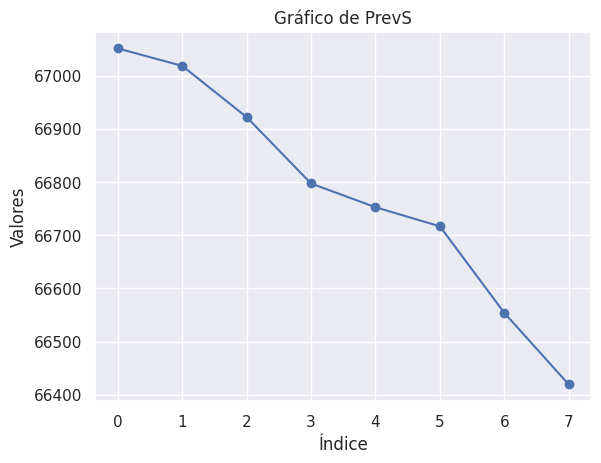

,Open,mm9d,mm14d,mm21d,mm55d,mm111d,mm350d,mme17d,mme55d,mme200d,mm12d,mm26d,MACD_linha,MACD_media,MACD_hist,RVI,RSI
3112,67051.080895,64551.958207,61310.930164,58098.856531,49391.500619,45626.732605,68376.576913,60790.677496,52286.157385,41486.294099,62921.439033,56757.191513,6164.247520,4416.901754,1747.345766,72.106624,78.219201
3113,67018.350175,65201.990171,62414.725545,58830.112789,49851.560323,45893.798154,68602.421637,61482.641127,52812.307127,41740.344408,63963.021274,57413.998851,6549.022423,4767.346622,1781.675800,63.154682,77.485927
3114,66922.029810,65700.921001,63499.832027,59534.265994,50295.609303,46159.139322,68824.867131,62087.017647,53316.225794,41990.908442,64783.932287,58075.098255,6708.834032,5125.053514,1583.780518,68.046311,77.087040
3115,66797.175792,66230.431852,64376.818635,60249.477862,50725.883380,46438.784558,69051.520201,62610.368552,53797.688294,42237.736973,65142.098303,58650.497895,6491.600409,5446.475940,1045.124469,64.744913,74.189854
3116,66752.565007,66632.160864,65068.352017,60938.955474,51162.433425,46703.037994,69277.151822,63070.612603,54260.362463,42481.665610,65607.473512,59220.299373,6387.174139,5741.378647,645.795492,66.337826,71.165473
3117,66716.674720,66451.674201,65369.601383,61646.671198,51624.946403,46968.086267,69496.389160,63475.730616,54705.230758,42722.809979,65964.558710,59780.107025,6184.451685,5963.706954,220.744732,63.378455,62.064658
3118,66553.981802,66760.333203,65754.309905,62373.817652,52078.208075,47227.839129,69716.513275,63817.758526,55128.400438,42959.936067,66341.425683,60352.876758,5988.548926,6127.568949,-139.020024,39.282450,66.510818
3119,66419.343847,66795.844498,66039.145012,63120.625879,52528.169086,47485.699631,69933.347628,64106.823561,55531.648417,43193.363010,66614.954012,60902.281810,5712.672202,6199.491270,-486.819067,83.829672,63.133545


In [ ]:
# Plotar os valores
plt.plot(prevs, marker='o', linestyle='-')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Gráfico de PrevS')
plt.grid(True)
plt.show()
features.tail(num_prev)

## Ultimate data request

- RNN
- K-means
- https://www.kaggle.com/code/princeiornongu/google-technical-analysis

In [ ]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 628.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=d35811d9a3604ac454b7052cb67c453c61ff0baa3b59f91f6988045924f8262b
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


,Timestamp,Open,High,Low,Close,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
349,2020-01-15 11:00:00,8803.78,8803.78,8723.58,8723.58,1.298477,11384.277949,53.0,0.721975,6328.455725,...,0.315825,8590.456562,8723.1955,8855.934438,3.043356,0.803545,0,-0.009151,0.000291,0.007962
350,2020-01-15 12:00:00,8723.36,8794.62,8723.36,8772.24,3.272499,28665.788673,99.0,1.476904,12933.522973,...,0.385779,8593.981620,8725.3095,8856.637380,3.010274,0.492578,-1,0.005562,0.000994,0.008080
351,2020-01-15 13:00:00,8771.31,8911.21,8771.31,8886.31,4.813334,42582.765283,100.0,2.259741,19972.817572,...,0.398506,8598.381849,8729.6985,8861.015151,3.008504,0.658440,0,0.012920,0.002584,0.008379
352,2020-01-15 14:00:00,8896.02,8896.02,8761.24,8853.36,15.024463,132828.098274,199.0,7.495320,66295.726584,...,0.381453,8586.984367,8734.8205,8882.656633,3.384984,1.045197,0,-0.003715,0.001744,0.008266
353,2020-01-15 15:00:00,8842.84,8852.40,8744.62,8772.71,6.422175,56498.635670,125.0,3.414176,30055.703792,...,0.425234,8584.005912,8738.8255,8893.645088,3.543258,0.835922,0,-0.009151,0.000291,0.008647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37084,2024-03-14 03:00:00,73008.17,73272.55,73008.17,73210.84,3.405210,249302.878243,521.0,1.875190,137296.869331,...,0.228246,72347.875526,72958.0530,73568.230474,1.672680,0.541068,0,0.002196,0.000535,0.002728
37085,2024-03-14 04:00:00,73210.87,73491.79,72668.27,72983.70,11.224690,822111.055319,1824.0,4.884340,358001.854192,...,0.557183,72357.570074,72975.5915,73593.612926,1.693776,0.690348,0,-0.003107,0.000050,0.002902
37086,2024-03-14 05:00:00,72983.70,73171.62,72751.63,73171.61,1.527180,111506.659846,403.0,1.245950,90985.741324,...,0.742139,72367.284218,72955.1765,73543.068782,1.611653,0.524259,0,0.002571,0.000386,0.002733
37087,2024-03-14 06:00:00,73171.61,73560.75,73115.39,73487.75,4.209810,308870.272856,676.0,1.766690,129682.153380,...,0.778254,72371.131860,72950.4885,73529.845140,1.588356,0.690834,0,0.004311,0.000909,0.002751


Coeficiente de determinação:99.98
[[73346.53391554 73652.13666755 73176.83046889]]
[[56815.9361387  57096.57317321 56640.89900226]
 [56933.23421273 57129.42871437 56703.52449539]
 [57010.4278192  57214.18167869 56816.41854312]
 ...
 [73099.75778473 73299.00617854 72805.25134608]
 [73378.09508205 73522.92754429 73059.36469263]
 [73346.53391554 73652.13666755 73176.83046889]]


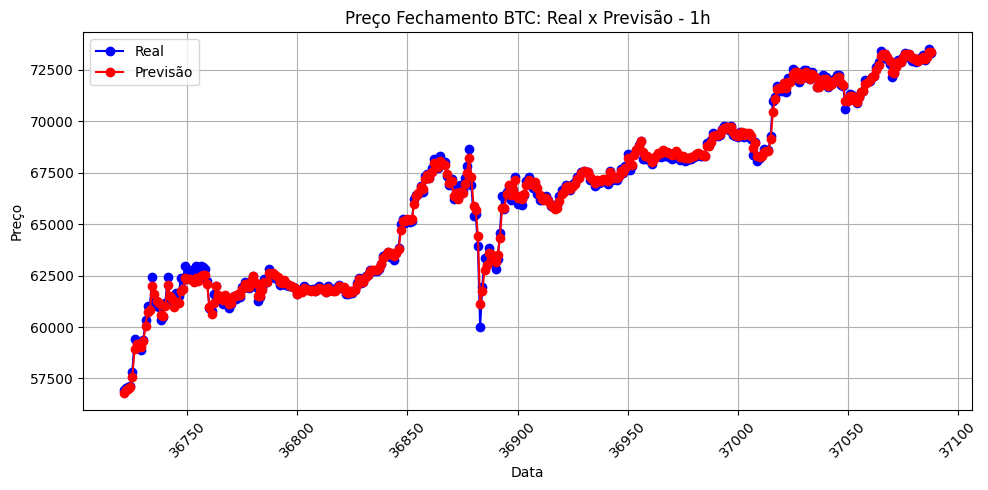

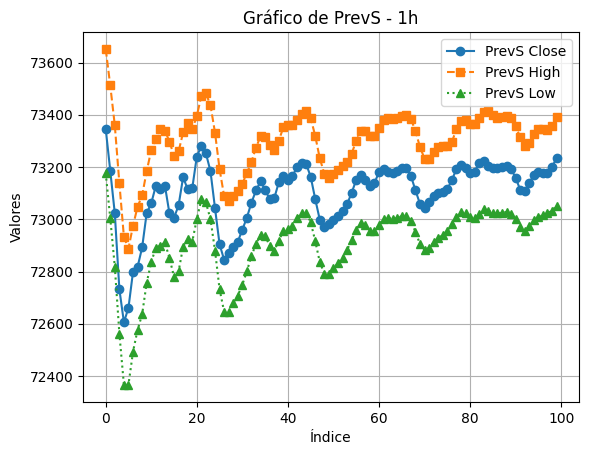

,Open,mm9d,mm14d,mm21d,mm55d,mm12d,mm26d,MACD_linha,MACD_media,MACD_hist,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
36740,73346.533916,73120.469324,73130.876708,72980.591139,72335.931708,73114.999493,72999.493228,115.506265,189.966031,-74.459765,...,0.616106,72343.767959,72977.714696,73611.661433,1.737371,0.790891,0.0,-0.001891,0.000161,0.002719
36741,73185.880537,73129.073828,73134.395318,72987.627355,72349.837172,73120.562038,73020.961710,99.600328,174.989572,-75.389244,...,0.505066,72370.187402,73000.184723,73630.182044,1.726016,0.647378,0.0,-0.002193,-0.000153,0.002686
36742,73022.195334,73150.108865,73113.433556,73001.232847,72364.880178,73105.479982,73027.196146,78.283837,156.973502,-78.689666,...,0.305576,72546.779052,73043.523489,73540.267927,1.360133,0.478532,0.0,-0.002239,-0.000431,0.002658
36743,72732.297770,73127.400840,73085.802683,73028.703217,72386.085956,73085.383130,73001.822983,83.560147,139.726553,-56.166406,...,0.107473,72664.007483,73064.082878,73464.158273,1.095136,0.085347,0.0,-0.003978,-0.000904,0.002743
36744,72605.663165,73082.677858,73043.122909,73042.253368,72400.158740,73043.485060,72976.449643,67.035417,120.798451,-53.763034,...,0.010742,72647.888359,73060.976536,73474.064713,1.130804,-0.051109,0.0,-0.001743,-0.001016,0.002536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36835,73179.771211,73163.262037,73178.874287,73177.286379,73139.766845,73172.272489,73158.513995,13.758494,30.962571,-17.204077,...,0.344675,73118.446168,73180.414575,73242.382983,0.169358,0.494809,0.0,0.000154,0.000031,0.000313
36836,73176.779074,73160.600188,73176.103204,73180.241456,73139.964069,73169.861625,73163.644153,6.217472,27.633468,-21.415996,...,0.361964,73121.281329,73181.736554,73242.191780,0.165219,0.458999,0.0,-0.000041,0.000021,0.000285
36837,73177.020770,73157.417465,73172.933551,73181.511993,73139.571676,73168.209064,73167.983918,0.225146,23.232311,-23.007165,...,0.305956,73120.693504,73181.005060,73241.316616,0.164828,0.466969,0.0,0.000003,0.000019,0.000283
36838,73199.231205,73158.014214,73172.470820,73181.872972,73139.259130,73168.532448,73172.265347,-3.732898,18.435944,-22.168843,...,0.312514,73120.955069,73180.529193,73240.103318,0.162814,0.656964,0.0,0.000303,0.000057,0.000293


,Timestamp,Open,High,Low,Close,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
349,2020-01-29 22:00:00,9373.51,9387.70,9300.15,9300.85,4.053483,37854.731951,952.0,3.122454,29166.151935,...,0.859283,8909.794473,9222.0110,9534.227527,6.771116,0.742618,0,-0.008155,0.000289,0.010272
350,2020-01-30 00:00:00,9300.42,9339.48,9205.00,9291.38,17.544382,162678.768146,1157.0,5.980784,55412.139375,...,0.800150,8933.218141,9235.1760,9537.133859,6.539298,0.608035,0,-0.001019,0.000115,0.010263
351,2020-01-30 02:00:00,9288.45,9289.51,9254.20,9279.79,3.263535,30276.926159,391.0,1.992420,18494.321876,...,0.518155,8973.598193,9250.9775,9528.356807,5.996757,0.567547,0,-0.001248,-0.000067,0.003729
352,2020-01-30 04:00:00,9292.68,9364.72,9292.68,9325.61,14.392442,134477.555123,430.0,4.465859,41723.500787,...,0.184822,8993.477866,9261.1460,9528.814134,5.780454,0.558905,0,0.004925,0.000599,0.003900
353,2020-01-30 06:00:00,9325.58,9396.31,9313.22,9389.61,8.382087,78337.067469,2652.0,8.105306,75751.953557,...,0.121307,9017.480443,9273.3290,9529.177557,5.517944,0.602113,0,0.006839,0.001431,0.004323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18542,2024-03-13 22:00:00,73203.18,73269.39,72884.74,73020.03,4.127110,301621.329808,962.0,2.050020,149916.848767,...,0.896923,70823.969624,72226.8005,73629.631376,3.884516,0.848003,0,-0.003405,0.000852,0.006199
18543,2024-03-14 00:00:00,73108.44,73203.60,72548.45,72912.57,7.665170,558500.336843,1486.0,2.811820,205062.482902,...,0.975703,70819.857620,72273.7805,73727.703380,4.023376,0.787037,0,-0.001473,0.000542,0.005925
18544,2024-03-14 02:00:00,72936.67,73272.55,72814.04,73210.84,5.742530,420008.660014,1059.0,3.991970,291895.968508,...,0.978495,70849.657417,72323.1140,73796.570583,4.074649,0.708203,0,0.004082,0.001014,0.005770
18545,2024-03-14 04:00:00,73210.87,73491.79,72668.27,73171.61,12.751870,933617.715164,2227.0,6.130290,448987.595516,...,0.953765,70864.482848,72381.1575,73897.832152,4.190800,0.773530,0,-0.000536,0.000807,0.005500


Coeficiente de determinação:99.97
[[73166.85641034 73600.08743518 72692.07673707]]
[[57680.93574984 57835.37564903 56999.54532248]
 [58931.37432344 58886.44715413 58105.0290881 ]
 [58878.44427308 59475.4231358  58734.05362692]
 [60030.63789413 60033.16354879 59208.69607608]
 [60708.49771079 60990.23573957 60221.78209176]
 [61228.9535502  61498.33142727 60705.97880447]
 [61039.75182708 61681.18660025 60782.50008408]
 [60678.0995305  61293.17983691 60248.77988422]
 [62047.10130297 61920.37187641 60840.35254284]
 [61495.24347791 62474.9675633  61419.36895174]
 [61219.36535461 62400.96185594 61189.90282158]
 [60918.12068678 61726.32086899 60372.20769997]
 [61589.86462012 62203.85843625 60854.7199889 ]
 [61955.36232302 62763.11742103 61406.87310219]
 [62140.34552118 63021.16787932 61643.36189882]
 [62408.10414054 63183.88947583 61815.91560928]
 [62484.63291761 63303.77958993 61944.29965937]
 [62556.96584576 63429.81670136 62059.10888015]
 [61105.09613714 62563.66378182 61018.72532503]
 [613

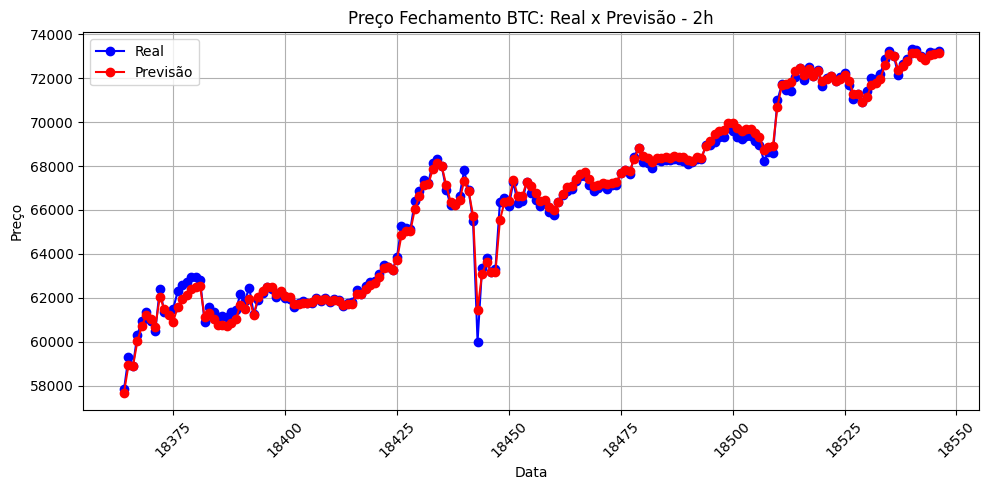

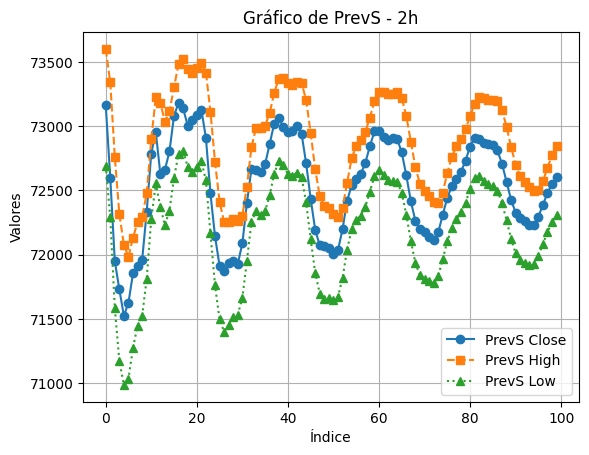

,Open,mm9d,mm14d,mm21d,mm55d,mm12d,mm26d,MACD_linha,MACD_media,MACD_hist,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
18198,73166.856410,73072.594046,72938.469744,72461.014115,71177.418298,73009.354701,72388.407554,620.947147,477.030011,143.917136,...,0.781870,70939.637312,72495.421821,74051.206329,4.292090,0.715787,0.0,-0.000065,0.000739,0.005475
18199,72599.884729,73065.049016,72969.445796,72500.396245,71255.007112,72953.897595,72412.705428,541.192167,524.718919,16.473247,...,0.524236,71154.213846,72570.763557,73987.313268,3.903913,0.510279,0.0,-0.007779,-0.000397,0.005392
18200,71948.729314,72962.433384,72904.347890,72541.142879,71320.411463,72863.115038,72404.239633,458.875405,550.046415,-91.171010,...,0.284254,71288.021982,72605.250523,73922.479063,3.628466,0.250794,0.0,-0.009010,-0.001545,0.005604
18201,71729.257557,72786.166446,72794.625572,72563.536572,71381.825418,72827.601501,72395.749539,431.851962,554.006853,-122.154891,...,0.050970,71503.979788,72646.360401,73788.741013,3.145046,0.098600,0.0,-0.003055,-0.001747,0.005603
18202,71523.062420,72599.486715,72686.407174,72592.870021,71428.395644,72732.207536,72375.482709,356.724827,539.570987,-182.846160,...,0.001383,71517.387775,72649.015522,73780.643268,3.115329,0.002507,0.0,-0.002879,-0.001897,0.004669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18293,72295.828234,72371.034461,72544.868885,72586.485334,72535.519491,72488.617911,72508.998227,-20.380316,126.081129,-146.461446,...,0.000000,72102.335060,72593.636139,73084.937219,1.353565,0.196919,0.0,0.000854,-0.000299,0.000796
18294,72388.205032,72335.414681,72508.343551,72583.853706,72525.049741,72449.482098,72517.039665,-67.557567,99.635275,-167.192842,...,0.041934,72087.586158,72586.438737,73085.291315,1.374506,0.301310,0.0,0.001277,-0.000089,0.000938
18295,72480.519156,72325.694364,72480.867080,72581.394947,72515.522795,72418.237525,72530.148163,-111.910638,66.536225,-178.446863,...,0.121187,72080.167393,72581.152317,73082.137241,1.380482,0.399565,0.0,0.001274,0.000093,0.001052
18296,72550.106209,72339.402114,72458.886468,72579.673931,72508.414726,72396.511712,72546.850414,-150.338702,28.576897,-178.915599,...,0.222748,72076.169819,72576.484972,73076.800125,1.378725,0.473638,0.0,0.000960,0.000208,0.001110


,Timestamp,Open,High,Low,Close,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
349,2020-02-27 20:00:00,8912.37,8912.37,8681.46,8802.94,16.237302,1.424650e+05,554.0,7.626812,66709.971990,...,0.165111,8535.790574,9199.0525,9862.314426,14.420223,0.283884,0,-0.010966,-0.003274,0.008859
350,2020-02-28 00:00:00,8818.72,8900.32,8807.83,8839.08,11.646863,1.032190e+05,353.0,6.716695,59534.379271,...,0.235127,8513.747532,9155.0860,9796.424468,14.010539,0.237762,0,0.004097,-0.002291,0.009156
351,2020-02-28 04:00:00,8837.02,8860.00,8698.24,8722.27,8.498712,7.444153e+04,216.0,3.708762,32531.669844,...,0.364956,8495.522890,9116.9440,9738.365110,13.632224,0.274771,0,-0.013303,-0.003759,0.009482
352,2020-02-28 08:00:00,8732.13,8775.83,8544.78,8577.27,22.726938,1.960682e+05,455.0,12.728243,109887.856639,...,0.528261,8481.308232,9070.2745,9659.240768,12.986735,0.212934,0,-0.016764,-0.005493,0.009507
353,2020-02-28 12:00:00,8590.69,8721.05,8451.67,8711.76,26.391489,2.271057e+05,336.0,13.230169,113871.563579,...,0.627889,8444.699032,9021.0430,9597.386968,12.777768,0.126653,-1,0.015558,-0.002686,0.010954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9271,2024-03-13 12:00:00,73038.12,73184.60,71699.12,72667.80,28.130890,2.040006e+06,4108.0,10.055670,731293.731220,...,0.845571,68394.223827,71097.6865,73801.149173,7.604924,0.858879,0,-0.005083,0.001952,0.006000
9272,2024-03-13 16:00:00,72667.79,73315.66,72401.08,73315.66,15.762540,1.150341e+06,2378.0,10.053540,734043.268047,...,0.690447,68600.549716,71263.0460,73925.542284,7.472306,0.763802,0,0.008876,0.002875,0.006177
9273,2024-03-13 20:00:00,73315.66,73377.26,72884.74,73020.03,10.282530,7.518820e+05,2078.0,6.111990,447124.020388,...,0.483845,68759.321982,71449.1695,74139.017018,7.529402,0.846951,0,-0.004040,0.001953,0.006077
9274,2024-03-14 00:00:00,73108.44,73272.55,72548.45,73210.84,13.407700,9.785090e+05,2545.0,6.803790,496958.451409,...,0.150512,69077.849177,71645.9315,74214.013823,7.168816,0.784747,0,0.002610,0.002040,0.006034


Coeficiente de determinação:99.92
[[73215.45641765 73826.79283417 72566.00483736]]
[[60417.72202014 60379.63246842 59272.57217679]
 [60746.61767571 61466.57941286 60329.4000951 ]
 [62060.9275013  62098.62126966 61004.50683047]
 [61700.48256889 62703.81900936 61461.20897544]
 [61485.15805899 62642.65899931 61222.56361225]
 [62004.00165857 62435.29803224 60978.2918141 ]
 [62390.40313415 63176.6353407  61688.55990011]
 [62377.85941849 63380.78639639 61839.03360743]
 [61386.27785721 62824.38399457 61052.17631049]
 [60878.09037982 61984.22855682 60176.80595343]
 [60741.95483328 61716.0938277  59914.89330426]
 [60920.84356944 61762.70512964 60032.36377576]
 [61226.95114399 62095.28089869 60384.36156718]
 [60816.94825087 62047.41527981 60329.52011504]
 [61563.35328217 62137.44669136 60595.33877543]
 [61865.36726374 62712.88621684 61224.55525374]
 [61914.12757103 62767.1367886  61408.19572791]
 [61621.99163642 62516.84732909 61196.57430678]
 [61315.6119526  62208.89915182 60885.37593042]
 [612

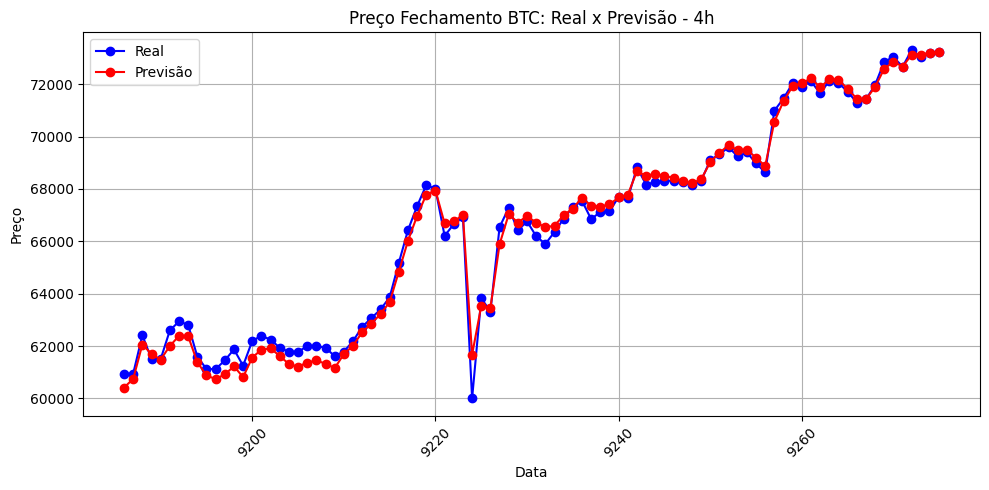

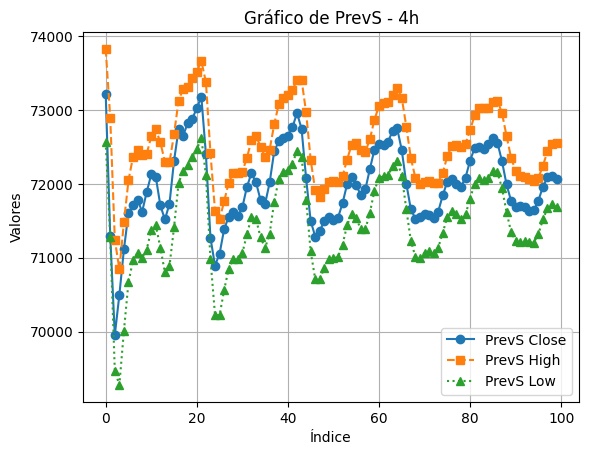

,Open,mm9d,mm14d,mm21d,mm55d,mm12d,mm26d,MACD_linha,MACD_media,MACD_hist,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
8927,73215.456418,72769.910713,72410.419030,71902.341258,68970.042844,72500.920535,71406.486785,1094.433750,1350.572062,-256.138312,...,0.044317,69949.073283,72051.490321,74153.907358,5.835874,0.776816,0.0,0.000063,0.001566,0.005632
8928,71290.762228,72749.999850,72390.760618,72015.265174,69063.463612,72437.650720,71490.873409,946.777311,1275.624270,-328.846959,...,0.044317,70751.289750,72186.738932,73622.188115,3.977044,0.187911,0.0,-0.026640,-0.002195,0.009209
8929,69951.646057,72517.649411,72232.389622,72080.305938,69123.065540,72285.882892,71513.605950,772.276942,1184.058304,-411.781362,...,0.014666,70462.557702,72132.046235,73801.534769,4.628979,-0.153014,0.0,-0.018963,-0.004430,0.010410
8930,70496.823528,72255.063137,72121.448445,72054.178487,69190.480877,72222.369019,71548.361086,674.007933,1087.291130,-413.283196,...,0.038383,70289.228965,72084.070912,73878.912858,4.979857,0.057831,0.0,0.007763,-0.002805,0.010700
8931,71111.451599,72040.988870,72074.204988,72037.755706,69393.283633,72192.493319,71622.909224,569.584095,991.780089,-422.195994,...,0.121230,70191.300254,72035.543991,73879.787729,5.120372,0.249466,0.0,0.008681,-0.001273,0.010919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9022,71773.448002,71799.607249,72063.168540,72086.847495,72024.172043,71993.432410,71999.903708,-6.471298,169.805478,-176.276776,...,0.000000,71397.932045,72089.643805,72781.355565,1.919032,0.271440,0.0,0.001871,-0.000282,0.001806
9023,71961.606318,71761.040354,72025.260505,72083.546782,72009.581708,71945.268385,72013.920830,-68.652446,140.307081,-208.959527,...,0.047127,71390.259963,72084.199420,72778.138877,1.925358,0.411669,0.0,0.002618,0.000105,0.002006
9024,72090.984744,71771.824386,71998.127142,72084.522530,71993.789384,71900.703269,72033.865770,-133.162500,101.898559,-235.061059,...,0.124418,71396.264449,72088.997280,72781.730111,1.921882,0.501435,0.0,0.001796,0.000331,0.002100
9025,72109.058703,71809.485866,71967.376005,72089.952586,71982.198681,71863.176251,72055.861863,-192.685612,54.891608,-247.577220,...,0.191393,71406.135803,72096.399580,72786.663356,1.914836,0.509170,0.0,0.000251,0.000320,0.002074


,Timestamp,Open,High,Low,Close,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
349,2020-04-25 16:00:00,7514.32,7565.14,7481.74,7541.17,12.882237,9.704539e+04,275.0,5.332125,4.020172e+04,...,0.912724,6664.759603,7194.7030,7724.646397,14.731488,0.801558,0,0.002368,0.003694,0.019219
350,2020-04-26 00:00:00,7537.51,7582.35,7525.64,7547.53,11.509149,8.695687e+04,364.0,7.736564,5.847968e+04,...,0.995594,6665.169848,7214.7625,7764.355152,15.235225,0.793624,0,0.000843,0.003314,0.018960
351,2020-04-26 08:00:00,7549.66,7705.38,7461.99,7554.22,48.705713,3.705984e+05,798.0,19.756520,1.506214e+05,...,0.995594,6672.063896,7237.4225,7802.781104,15.623203,0.776141,-1,0.000886,0.002990,0.018986
352,2020-04-26 16:00:00,7542.28,7694.13,7534.25,7694.13,28.780023,2.187957e+05,529.0,9.720064,7.402684e+04,...,0.989767,6680.805409,7258.4940,7836.182591,15.917588,0.745622,0,0.018351,0.005039,0.019145
353,2020-04-27 00:00:00,7695.78,7791.73,7633.17,7692.89,41.626432,3.214321e+05,825.0,22.633557,1.749901e+05,...,0.994172,6677.706773,7284.3515,7890.996227,16.656108,0.839102,1,-0.000161,0.004345,0.018592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4636,2024-03-12 16:00:00,71772.86,71849.64,69008.63,71420.43,56.619690,3.990327e+06,7319.0,26.043720,1.838866e+06,...,0.971531,64661.463115,68709.9735,72758.483885,11.784346,0.878273,0,-0.004125,0.003091,0.009509
4637,2024-03-13 00:00:00,71469.96,72950.00,71355.77,72860.10,21.842100,1.574364e+06,3675.0,13.153100,9.482756e+05,...,0.919828,64865.277719,68956.1540,73047.030281,11.865152,0.807245,0,0.019957,0.005340,0.010367
4638,2024-03-13 08:00:00,72860.10,73559.04,71699.12,72667.80,55.561090,4.051025e+06,7031.0,32.836620,2.401699e+06,...,0.903317,65028.714441,69278.9380,73529.161559,12.269887,0.921291,0,-0.002643,0.004276,0.010549
4639,2024-03-13 16:00:00,72667.79,73377.26,72401.08,73020.03,26.045070,1.902223e+06,4456.0,16.165530,1.181167e+06,...,0.851496,65355.459247,69602.6375,73849.815753,12.204073,0.860846,0,0.004835,0.004350,0.010523


Coeficiente de determinação:99.81
[[73072.14730999 73980.18066497 72161.90017702]]
[[62535.70776093 63371.61633582 61806.95991797]
 [62655.87832293 63419.42722806 61693.98209172]
 [62923.3800124  63643.19372431 61750.89379835]
 [61660.31856437 63168.88842357 60817.66032723]
 [61598.55654643 62305.34412824 60051.05783545]
 [61356.26124411 62345.2536866  60005.78608935]
 [62141.5045464  62728.35835361 60462.92194602]
 [61929.9876736  63218.76698659 60757.92607986]
 [61744.39363984 62963.645764   60448.15505324]
 [61939.43325461 62905.25230681 60474.21660744]
 [61705.61399478 62895.83764021 60415.14619005]
 [62112.45433298 62934.15359124 60559.85237986]
 [62844.04604    63433.15698263 61505.54553773]
 [63607.36040181 64154.48369106 62470.95414428]
 [65708.0542917  65728.83266028 64130.32829972]
 [67585.49567505 67917.90115677 66355.9651792 ]
 [66519.05737542 68185.79421051 66148.0236298 ]
 [66756.22915759 67233.77477489 65571.97018641]
 [64566.91524395 66544.71070685 64256.52135542]
 [660

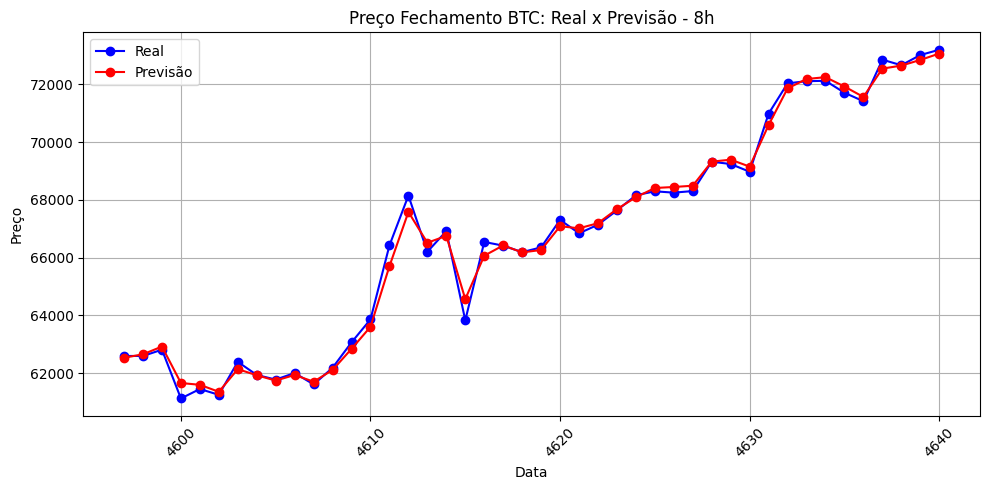

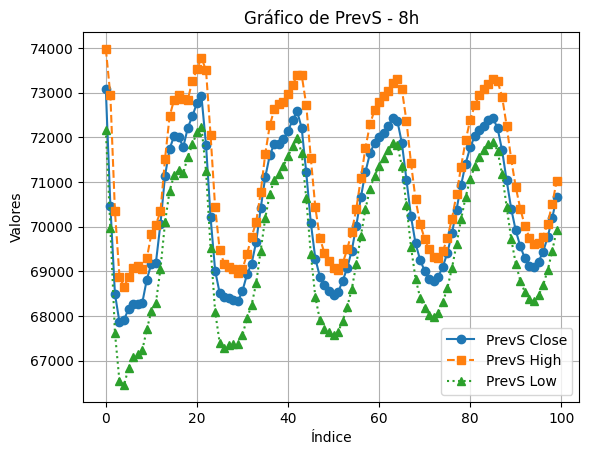

,Open,mm9d,mm14d,mm21d,mm55d,mm12d,mm26d,MACD_linha,MACD_media,MACD_hist,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
4292,73072.147310,72369.030812,71297.959094,70088.906062,64589.829042,71704.944776,69277.231435,2427.713341,2112.461098,315.252243,...,0.804213,65966.865752,70229.058365,74491.250979,12.137975,0.833524,0.0,-0.000497,0.003491,0.010477
4293,70464.558681,72189.316221,71448.892571,70240.272666,64934.701745,71812.557999,69532.402538,2280.155461,2158.173093,121.982368,...,0.533388,66440.654018,70410.036300,74379.418581,11.275047,0.506868,0.0,-0.036337,-0.001819,0.014790
4294,68494.735800,71786.603532,71387.045128,70318.831514,65239.242396,71777.172649,69607.340454,2169.832196,2187.944719,-18.112523,...,0.255760,66669.007214,70472.637590,74276.267965,10.794630,0.239998,0.0,-0.028353,-0.005357,0.016783
4295,67856.424784,71307.446286,71292.989755,70348.056027,65539.231756,71511.416381,69663.186791,1848.229590,2181.178812,-332.949222,...,0.000000,66713.676901,70484.118829,74254.560757,10.698699,0.151540,0.0,-0.009363,-0.005891,0.016927
4296,67910.456943,70878.290391,71220.925251,70361.563501,65815.446428,71163.788626,69729.212058,1434.576568,2130.585653,-696.009085,...,0.009598,66670.340984,70472.030676,74273.720367,10.789216,0.163101,0.0,0.000796,-0.005000,0.014627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,69215.725668,69927.986823,70771.402279,70789.914259,70508.910192,70531.029233,70430.259017,100.770215,710.046340,-609.276125,...,0.000000,68457.505401,70858.593975,73259.682550,6.777127,0.157891,0.0,0.001591,-0.002055,0.004113
4388,69433.661288,69675.335081,70576.331976,70790.740038,70455.314381,70285.188915,70446.659780,-161.470865,608.019031,-769.489897,...,0.006944,68394.951602,70837.677748,73280.403895,6.896686,0.212613,0.0,0.003144,-0.001362,0.004234
4389,69760.307157,69533.511967,70397.594231,70786.374387,70404.003781,70063.235845,70482.384819,-419.148974,461.179104,-880.328078,...,0.032260,68325.911926,70806.579217,73287.246508,7.006884,0.289115,0.0,0.004693,-0.000555,0.004564
4390,70187.269684,69509.795401,70240.703130,70777.088286,70367.234386,69894.426628,70536.623208,-642.196580,280.689581,-922.886161,...,0.079191,68275.197661,70769.603480,73264.009299,7.049371,0.383272,0.0,0.006102,0.000333,0.005009


,Timestamp,Open,High,Low,Close,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
349,2020-12-13,18808.78,19420.37,18711.27,19175.96,193.794492,3.704279e+06,6651.0,94.434348,1.801702e+06,...,0.480762,17207.519793,18591.3990,19975.278207,14.887306,0.578540,0,0.019202,0.004581,0.035663
350,2020-12-14,19170.85,19343.45,19007.14,19273.23,203.652912,3.904966e+06,5939.0,87.057074,1.670715e+06,...,0.467728,17229.896368,18631.7925,20033.688632,15.048430,0.692260,0,0.005060,0.004645,0.028055
351,2020-12-15,19279.38,19567.68,19056.50,19428.77,367.574565,7.106634e+06,7968.0,159.649191,3.088545e+06,...,0.350950,17225.927238,18637.7855,20049.643762,15.150494,0.727216,0,0.008038,0.005097,0.024759
352,2020-12-16,19434.32,21537.30,19284.48,21350.80,691.829970,1.410138e+07,12014.0,336.620364,6.852883e+06,...,0.438902,17219.687783,18673.5835,20127.479217,15.571684,0.761620,0,0.094334,0.016996,0.034697
353,2020-12-17,21341.20,23801.60,21235.72,22812.74,913.689501,2.069573e+07,18731.0,455.105037,1.030059e+07,...,0.616371,17177.389202,18882.4190,20587.448798,18.059442,1.221038,0,0.066230,0.023560,0.038090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,2024-03-10,68351.49,69999.00,68150.00,68978.46,101.725770,7.037952e+06,11623.0,58.061040,4.021995e+06,...,0.562692,46222.671465,59268.2500,72313.828535,44.022149,0.848135,0,0.009753,0.012985,0.039526
1543,2024-03-11,68919.36,72754.15,67800.00,72115.58,164.645620,1.167580e+07,20295.0,101.499700,7.197236e+06,...,0.594926,46914.135823,60126.6205,73339.105177,43.948868,0.832744,0,0.044476,0.017184,0.039134
1544,2024-03-12,72119.15,72945.19,69008.63,71420.43,116.848860,8.328015e+06,16891.0,53.207140,3.798731e+06,...,0.581450,47439.773804,61118.3170,74796.860196,44.760863,0.902120,0,-0.009686,0.013601,0.039108
1545,2024-03-13,71469.96,73559.04,71355.77,73020.03,103.448260,7.527613e+06,15162.0,62.155250,4.531142e+06,...,0.486610,48402.917110,62098.5170,75794.116890,44.109266,0.842133,0,0.022150,0.014741,0.033037


Coeficiente de determinação:98.37
[[73345.52619691 73788.07421897 70494.71678552]]
[[62187.33901229 62864.1592503  60767.67986718]
 [63056.21814508 63043.42702065 61050.4582806 ]
 [67339.95738407 66039.72416284 63927.18321615]
 [64558.34162956 67117.15843768 64273.73635491]
 [65926.72794379 65969.42404389 62803.5691612 ]
 [66794.7967617  67540.52736805 64274.4695624 ]
 [68174.60189187 68456.25798161 65278.52914487]
 [68518.72752089 69315.3977054  65865.26393362]
 [69095.81658591 69795.50392733 66166.91449981]
 [71662.18331316 71537.43747603 67866.27782834]
 [71657.27603312 72947.72276257 69126.59015726]
 [73042.47857749 72881.53735978 69624.81898593]
 [73345.52619691 73788.07421897 70494.71678551]]


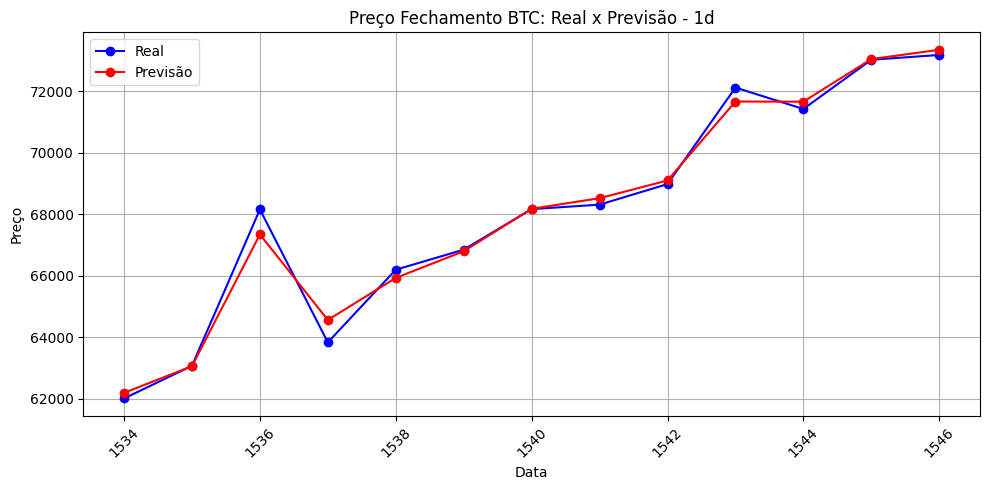

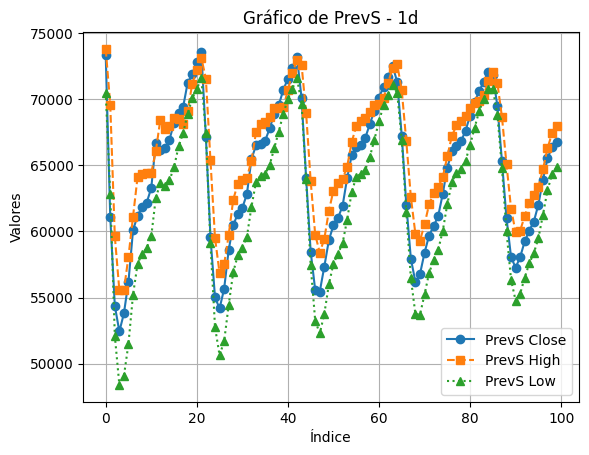

,Open,mm9d,mm14d,mm21d,mm55d,mm12d,mm26d,MACD_linha,MACD_media,MACD_hist,...,est_RSI_D,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,FRAC,LogReturn,EWMA_LogReturn,Volatility
1198,73345.526197,69833.882911,67705.191157,63671.769819,52572.426294,68621.155516,61401.824469,7219.331047,6760.657189,458.673858,...,0.237585,51346.384085,64318.941310,77291.498534,40.338218,0.847911,0.0,0.003238,0.011751,0.031886
1199,61100.194241,69267.926715,67611.456460,64165.667640,52924.393463,68457.097536,61747.216555,6709.880981,6884.204036,-174.323055,...,0.133156,53095.279633,64795.837522,76496.395411,36.115153,0.342074,0.0,-0.182666,-0.014172,0.061030
1200,54377.556058,67882.655166,67066.544035,64299.728881,53157.210664,67317.733875,61848.201404,5469.532471,6803.020065,-1333.487595,...,0.119880,53770.539353,64927.465325,76084.391296,34.367354,0.027204,0.0,-0.116564,-0.027824,0.068040
1201,52439.546188,66136.802520,66307.305192,64332.802509,53391.498594,66368.520224,61854.137026,4514.383197,6566.222038,-2051.838840,...,0.000000,53266.004003,64827.088134,76388.172266,35.667448,-0.035743,0.0,-0.036290,-0.028953,0.063348
1202,53808.355047,64520.898637,65290.050552,64302.386559,53644.914322,65336.399811,61928.844528,3407.555283,6178.372304,-2770.817021,...,0.000000,52589.754004,64664.155887,76738.557769,37.344961,0.050462,0.0,0.025768,-0.021657,0.062849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,62029.664586,60196.331473,64073.661986,65107.596153,64411.797160,62926.878914,64220.355396,-1293.476482,1638.406820,-2931.883302,...,0.046627,55181.219091,65123.215983,75065.212875,30.532881,0.344420,0.0,0.020927,-0.000643,0.031541
1294,63894.054421,60039.946610,63594.629314,65064.684480,64257.869466,62244.621964,64432.372280,-2187.750316,1050.219622,-3237.969938,...,0.058083,55069.490758,65015.909433,74962.328108,30.596876,0.443605,0.0,0.029614,0.003391,0.032764
1295,65520.756382,60543.527944,63181.239841,65039.949764,64118.869433,61718.704250,64656.589870,-2937.885620,379.686050,-3317.571670,...,0.087750,55041.365521,64968.876326,74896.387131,30.560820,0.527795,0.0,0.025141,0.006291,0.033613
1296,66369.780702,61466.385225,62773.285761,65035.586058,64051.413183,61462.631230,64886.161304,-3423.530074,-328.824536,-3094.705538,...,0.116098,55033.964900,64947.368364,74860.771829,30.527499,0.571742,0.0,0.012875,0.007169,0.033698


In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas_ta as ta


# DFA (Análise de Flutuação Detendida)
# MFDFA (Análise de Flutuação com Tendência Multifractal)
# DCCA (Análise de Correlação Cruzada Detendida)
# MFDCCA (Análise de Correlação Cruzada Multifractal Detendida)
# HT (expoente de Hurst dependente do tempo)


def calculate_rsi(data, window=14):
    # Calcular as variações de preço
    deltas = data['Open'].diff()

    # Separar as variações de preço em positivas e negativas
    gain = deltas.where(deltas > 0, 0)
    loss = -deltas.where(deltas < 0, 0)

    # Calcular as médias móveis
    average_gain = gain.rolling(window=window, min_periods=1).mean()
    average_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calcular o RSI
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


def calculate_rvi(data, window=10):
    close_prices_diff = data['Open'].diff()
    upward_movements = close_prices_diff.where(close_prices_diff > 0, 0).rolling(window=window).mean()
    downward_movements = close_prices_diff.where(close_prices_diff < 0, 0).abs().rolling(window=window).mean()

    # Calcular o RVI
    rvi = (upward_movements / (upward_movements + downward_movements)) * 100

    return rvi


def selectAnaliseTec(dados):
    qtd_data = len(dados)
    train_size = int(0.89 * qtd_data)
    test_size = int(0.1 * qtd_data)
    val_size = qtd_data - train_size - test_size

    #separando as features e labels
    features = dados.drop(['Close', 'High', 'Low', 'Volume'], axis=1)
    labels = dados[['Close', 'High', 'Low']]  # 'Volume'

    return qtd_data, train_size, test_size, val_size, features, labels


def hurst_dfa(data):
    # Pré-processamento da série temporal
    data = np.array(data)
    data = data - np.mean(data)
    data = data / np.std(data)

    # Cálculo da função de flutuação
    n_windows = len(data) // 2
    ws = np.logspace(np.log10(2), np.log10(n_windows), n_windows)
    F = np.zeros(n_windows)
    for i, w in enumerate(ws):
        n = int(w)
        profile = np.cumsum(data[:n]) - np.mean(data[:n]) * np.arange(n)
        F[i] = np.sqrt(np.mean((profile**2)[1:]))

    # Ajuste da função de flutuação
    H, H_intercept = np.polyfit(np.log10(ws), np.log10(F), 1)

    return H, H_intercept


def identify_fractals(data):
    is_fractals = pd.Series(0, index=data.index, name='Fractal')

    for i in range(2, len(data) - 2):
        prev_high = data['High'].iloc[i-1]
        next_high = data['High'].iloc[i+1]
        next_next_high = data['High'].iloc[i+2]
        prev_low = data['Low'].iloc[i-1]
        next_low = data['Low'].iloc[i+1]
        next_next_low = data['Low'].iloc[i+2]
        prev_close = data['Close'].iloc[i-1]
        curr_high = data['High'].iloc[i]
        curr_low = data['Low'].iloc[i]
        curr_close = data['Close'].iloc[i]

        # Fractal de Alta
        if (curr_high > prev_high and curr_high > next_high and curr_high > next_next_high and
            curr_high == data['High'].iloc[i-2:i+1].max() and curr_close < prev_close):
            is_fractals[i] = 1

        # Fractal de Baixa
        elif (curr_low < prev_low and curr_low < next_low and curr_low < next_next_low and
              curr_low == data['Low'].iloc[i-2:i+1].min() and curr_close > prev_close):
            is_fractals[i] = -1

    data = data.join(is_fractals)
    return data


ano = str(date.today().year)
mes = str(date.today().month).zfill(2)
dia = str(date.today().day + 1).zfill(2)

symbol = 'BTCUSDT'
list_time = ['1h', '2h', '4h', '8h', '1d']  # '3d' Quando for 2025 ou pelo yfinance

start_time = '2020-01-01 00:00:00'
end_time = f'{ano}-{mes}-{dia} 00:00:00'

start_timestamp = int(pd.Timestamp(start_time).timestamp()) * 1000
end_timestamp = int(pd.Timestamp(end_time).timestamp()) * 1000

for time in list_time:
    interval = time
    limit = 1000

    if interval == '1h':
        ace = 1
    elif interval == '2h':
        ace = 2
    elif interval == '4h':
        ace = 4
    elif interval == '8h':
        ace = 8
    elif interval == '1d':
        ace = 24
        start_time = '2019-01-01 00:00:00'
    elif interval == '3d':
        ace = 72
        start_time = '2015-01-01 00:00:00'

    dados_concatenados = pd.DataFrame()

    for i in range(start_timestamp, end_timestamp, 86400000*5*ace):
        url = f"https://api.binance.us/api/v3/klines?symbol={symbol}&interval={interval}&startTime={i}&endTime={i+86400000*5*ace}&limit={limit}"
        response = requests.get(url)

        if response.status_code == 200:
            dados_historicos = response.json()

            colunas = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBaseAssetVolume', 'TakerBuyQuoteAssetVolume', 'Ignore']
            dados = pd.DataFrame(dados_historicos, columns=colunas).astype(float)

            dados['Timestamp'] = pd.to_datetime(dados['Timestamp'], unit='ms')
            dados = dados.drop(columns='Ignore')
            dados = dados.drop(columns='CloseTime')
            dados = dados.reset_index(drop=True)

            dados_concatenados = pd.concat([dados_concatenados, dados], ignore_index=True)
        else:
            print(f"Erro ao fazer a solicitação: {response.status_code}")

    dados = dados_concatenados
    dados['mm9d'] = dados['Close'].rolling(9).mean()
    dados['mm14d'] = dados['Close'].rolling(14).mean()
    dados['mm21d'] = dados['Close'].rolling(21).mean()
    dados['mm55d'] = dados['Close'].rolling(55).mean()
    dados['mm12d'] = dados['Close'].rolling(12).mean()
    dados['mm26d'] = dados['Close'].rolling(26).mean()
    dados['MACD_linha'] = dados['mm12d'] - dados['mm26d']
    dados['MACD_media'] = dados['MACD_linha'].rolling(9).mean()
    dados['MACD_hist'] = dados['MACD_linha'] - dados['MACD_media']
    dados['RSI'] = calculate_rsi(dados)
    dados['RVI'] = calculate_rvi(dados)
    dados['mm111d'] = dados['Close'].rolling(111).mean()
    dados['mm350d'] = dados['Close'].rolling(350).mean()*2
    dados['mme17d'] = dados['Close'].ewm(span=17, adjust=False).mean()
    dados['mme55d'] = dados['Close'].ewm(span=55, adjust=False).mean()
    dados['mme200d'] = dados['Close'].ewm(span=200, adjust=False).mean()
    dados['est_RSI'] = (dados['RSI'] - dados['RSI'].rolling(14).min()) / (dados['RSI'].rolling(14).max() - dados['RSI'].rolling(14).min())
    dados['est_RSI_D'] = dados['est_RSI'].rolling(3).mean()
    bb_plot = dados.ta.bbands(close='Open', length=20, std=2)
    dados = pd.concat([dados, bb_plot], axis=1)
    dados['FRAC'] = identify_fractals(dados.loc[:,['Open', 'High', 'Low', 'Close']])['Fractal']

    dados['LogReturn'] = np.log(dados['Close'] / dados['Close'].shift(1))
    dados['EWMA_LogReturn'] = dados['LogReturn'].ewm(span=14, adjust=False).mean()
    dados['Volatility'] = dados['LogReturn'].rolling(14).std()
    # dados['Close'] = dados['Close'].shift(-1)

    H_list = []
    H_intercept_list = []
    for i in range(0, len(dados) - 100):
        if i < 100:
            H_list.append(None)
            H_intercept_list.append(None)

        tam = i + 100
        H, H_intercept = hurst_dfa(dados['Open'][i:tam])

        H_list.append(H)
        H_intercept_list.append(H_intercept)

    dados.insert(27, "H", H_list)
    dados.insert(28, "H_intercept", H_intercept_list)


    dados.dropna(inplace=True)
    display(dados)

    dados.to_csv(f'{symbol}-{interval}.csv', index=False)

    qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(dados)

    features = dados.loc[:,['Open', 'mm9d', 'mm14d', 'mm21d', 'mm55d', 'mm12d',
                            'mm26d', 'MACD_linha', 'MACD_media', 'MACD_hist',
                            'RVI', 'RSI', 'mm111d', 'mm350d', 'mme17d', 'mme55d',
                            'mme200d', 'H', 'H_intercept', 'est_RSI', 'est_RSI_D',
                            'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0',
                            'BBP_20_2.0', 'FRAC', 'LogReturn', 'EWMA_LogReturn',
                            'Volatility']]
    #Separa os dados de treino teste e validação
    X_train = features[:train_size]
    X_test = features[train_size:train_size + test_size -1]

    y_train = labels[:train_size]
    y_test = labels[train_size:train_size + test_size -1]

    # Normalizando os dados de entrada(features)

    # Gerando o novo padrão
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
    X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

    # treinamento usando regressão linear
    lr = linear_model.LinearRegression()
    lr.fit(X_train_scale, y_train)
    pred = lr.predict(X_test_scale)
    cd_close = r2_score(y_test, pred)

    print(f'Coeficiente de determinação:{cd_close * 100:.2f}')

    valor_novo = features.tail(1)  # Mudar para pegar o valor da API

    #executando a previsão

    previsao = scaler.transform(valor_novo)

    # pred_close = float(lr.predict(previsao)[0])
    print(lr.predict(previsao))
    # print(f'Prev_close: {pred_close:.2f}')


    #executando a previsão recursiva

    num_prev = 100
    prevs_c = []
    prevs_h = []
    prevs_l = []
    # prevs_v = []
    for i in range(1, num_prev+1):
        valor_novo = features.tail(1)

        previsao = scaler.transform(valor_novo)

        # pred_close = float(lr.predict(previsao)[0])
        # display(features)
        lista_previsao = lr.predict(previsao)
        pred_close = float(lista_previsao[0][0])
        pred_high = float(lista_previsao[0][1])
        pred_low = float(lista_previsao[0][2])
        # pred_vol = float(lista_previsao[0][3])

        new_row = {'Open': pred_close}
        # Cria um novo DataFrame com a nova linha
        new_df = pd.DataFrame([new_row])

        # Concatena o novo DataFrame com o DataFrame existente
        features = pd.concat([features, new_df], ignore_index=True)

        # Calcula as médias móveis para a última linha adicionada
        row_index = features.index[-1]
        features.loc[row_index, 'mm9d'] = features['Open'].iloc[:row_index+1].rolling(9).mean().iat[-1]
        features.loc[row_index, 'mm14d'] = features['Open'].iloc[:row_index+1].rolling(14).mean().iat[-1]
        features.loc[row_index, 'mm21d'] = features['Open'].iloc[:row_index+1].rolling(21).mean().iat[-1]
        features.loc[row_index, 'mm55d'] = features['Open'].iloc[:row_index+1].rolling(55).mean().iat[-1]
        features.loc[row_index, 'mm111d'] = features['Open'].iloc[:row_index+1].rolling(111).mean().iat[-1]
        mm350d = features['Open'].iloc[:row_index+1].rolling(350).mean()
        features.loc[row_index, 'mm350d'] = (mm350d * 2).iat[-1]
        features.loc[row_index, 'mme17d'] = features['Open'].iloc[:row_index+1].ewm(span=17, adjust=False).mean().iat[-1]
        features.loc[row_index, 'mme55d'] = features['Open'].iloc[:row_index+1].ewm(span=55, adjust=False).mean().iat[-1]
        features.loc[row_index, 'mme200d'] = features['Open'].iloc[:row_index+1].ewm(span=200, adjust=False).mean().iat[-1]
        features.loc[row_index, 'mm12d'] = features['Open'].iloc[:row_index+1].rolling(12).mean().iat[-1]
        features.loc[row_index, 'mm26d'] = features['Open'].iloc[:row_index+1].rolling(26).mean().iat[-1]
        features.loc[row_index, 'MACD_linha'] = (features['mm12d'] - features['mm26d']).iat[-1]
        features.loc[row_index, 'MACD_media'] = features['MACD_linha'].iloc[:row_index+1].rolling(9).mean().iat[-1]
        features.loc[row_index, 'MACD_hist'] = (features['MACD_linha'] - features['MACD_media']).iat[-1]
        features.loc[row_index, 'RSI'] = calculate_rsi(features).iat[-1]
        features.loc[row_index, 'RVI'] = calculate_rvi(features).iat[-1]
        features.loc[row_index, 'est_RSI'] = ((features['RSI'] - features['RSI'].rolling(14).min()) / (features['RSI'].rolling(14).max() - features['RSI'].rolling(14).min())).iat[-1]
        features.loc[row_index, 'est_RSI_D'] = features['est_RSI'].iloc[:row_index+1].rolling(3).mean().iat[-1]
        H, H_intercept = hurst_dfa(features['Open'][(len(features) - 100):])
        features.loc[row_index, 'H'] = H
        features.loc[row_index, 'H_intercept'] = H_intercept
        first_five = features.ta.bbands(close='Open', length=20, std=2)


        bb_lower_list = first_five['BBL_20_2.0'].tolist()
        bb_middle_list = first_five['BBM_20_2.0'].tolist()
        bb_upper_list = first_five['BBU_20_2.0'].tolist()
        bb_b_list = first_five['BBB_20_2.0'].tolist()
        bb_p_list = first_five['BBP_20_2.0'].tolist()

        bb_lower_list = [float(i) for i in bb_lower_list]
        bb_middle_list = [float(i) for i in bb_middle_list]
        bb_upper_list = [float(i) for i in bb_upper_list]
        bb_b_list = [float(i) for i in bb_b_list]
        bb_p_list = [float(i) for i in bb_p_list]

        features['BBL_20_2.0'] = bb_lower_list
        features['BBM_20_2.0'] = bb_middle_list
        features['BBU_20_2.0'] = bb_upper_list
        features['BBB_20_2.0'] = bb_b_list
        features['BBP_20_2.0'] = bb_p_list

        # Add Frac

        # Tentar calcular o primeiro fractal pelo .tail(), os primeiros 4?, Guardar esses valores em uma lista?
        # Vou ter de criar um data frame especifico pra isso, com os ultimos 4 valores de dados e adicioando um novo valor ao final a cada iteração, depois pegar esse valor que for calculado (o fractal)
        # Tentar calcular o fractal pelos valores em listas
        # Adicionar o  fractal calculado a features
        if i == 1:
            data = dados[['Open', 'High', 'Low', 'Close']]

        data_nl = pd.DataFrame({
            'Open': features['Open'].tail(1),
            'High': pred_high,
            'Low': pred_low,
            'Close': pred_close
        })

        data = pd.concat([data, data_nl], ignore_index=True)

        data['FRAC'] = identify_fractals(data)['Fractal']
        features.loc[row_index, 'FRAC'] = data['FRAC'].tail(1).iat[-1]

        features.loc[row_index, 'LogReturn'] = (np.log(features['Open'] / features['Open'].shift(1))).iat[-1]
        features.loc[row_index, 'EWMA_LogReturn'] = features['LogReturn'].iloc[:row_index+1].ewm(span=14, adjust=False).mean().iat[-1]
        features.loc[row_index, 'Volatility'] = features['LogReturn'].iloc[:row_index+1].rolling(14).std().iat[-1]
        # features.dropna(inplace=True)


        prevs_c.append(pred_close)
        prevs_h.append(pred_high)
        prevs_l.append(pred_low)
        # prevs_v.append(pred_vol)
        # print(f'Prev_close: {pred_close:.2f}')

    # Teste

    # Add Low e High
    test = train_size + test_size
    previsao = scaler.transform(features[test:qtd_data])

    data_final_full = dados.index
    data_final = data_final_full[test:qtd_data]

    real_full = dados['Close']
    real = real_full[test:qtd_data]

    pred_lr = lr.predict(previsao)
    print(pred_lr)

    list_pred_lr = []
    for pred_c in pred_lr:
        list_pred_lr.append(pred_c[0])

    df_final = pd.DataFrame({'Datetime': data_final, 'real': real, 'Previsao': list_pred_lr})
    # df_final['real'] = df_final['real'].shift(+1)
    df_final.set_index('Datetime', inplace=True)
    df_final = df_final.dropna()


    # Convertendo os valores em listas
    timestamps = df_final.index.tolist()
    real_values = df_final['real'].astype(int).tolist()
    predicted_values = df_final['Previsao'].astype(int).tolist()

    # Plot dos valores
    plt.figure(figsize=(10, 5))
    plt.plot(timestamps, real_values, label='Real', color='blue', marker='o')
    plt.plot(timestamps, predicted_values, label='Previsão', color='red', marker='o')

    # Adiciona rótulos e legendas
    plt.title(f'Preço Fechamento BTC: Real x Previsão - {interval}')
    plt.xlabel('Data')
    plt.ylabel('Preço')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)


    plt.tight_layout()

    # Mostra o gráfico
    plt.show()

    # Plotar os valores
    # Plotando a série prevs_c
    plt.plot(prevs_c, marker='o', linestyle='-', label='PrevS Close')
    # Plotando a série prevs_h
    plt.plot(prevs_h, marker='s', linestyle='--', label='PrevS High')
    # Plotando a série prevs_l
    plt.plot(prevs_l, marker='^', linestyle=':', label='PrevS Low')
    # Plotando a série prevs_v
    #plt.plot(prevs_v, marker='D', linestyle='-.', label='PrevS Vol')

    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.title(f'Gráfico de PrevS - {interval}')
    plt.grid(True)
    plt.legend() # Adiciona uma legenda ao gráfico
    plt.show()

    # Exibindo as últimas linhas do DataFrame features
    display(features.tail(num_prev))


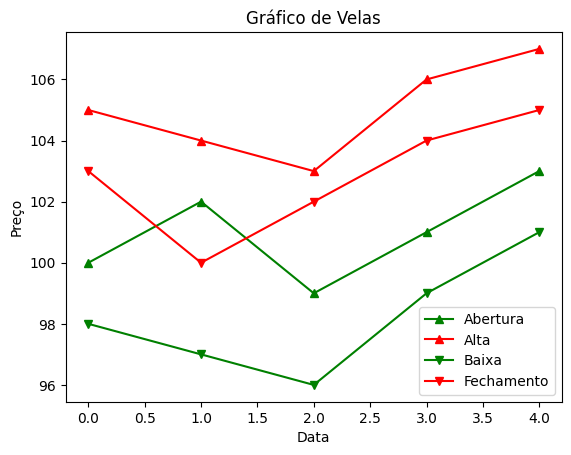

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# # Carrega os dados
# df = pd.read_csv('dados_acoes.csv')

# Define as datas e os preços
datas = range(0, len(dados))
abertura = dados['Open']
alta = dados['High']
baixa = dados['Low']
fechamento = dados['Close']

# Cria o gráfico de velas
plt.plot(datas, abertura, color='g', marker='^', label='Abertura')
plt.plot(datas, alta, color='r', marker='^', label='Alta')
plt.plot(datas, baixa, color='g', marker='v', label='Baixa')
plt.plot(datas, fechamento, color='r', marker='v', label='Fechamento')

# Personaliza o gráfico
plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Gráfico de Velas')
plt.legend()

# Mostra o gráfico
plt.show()

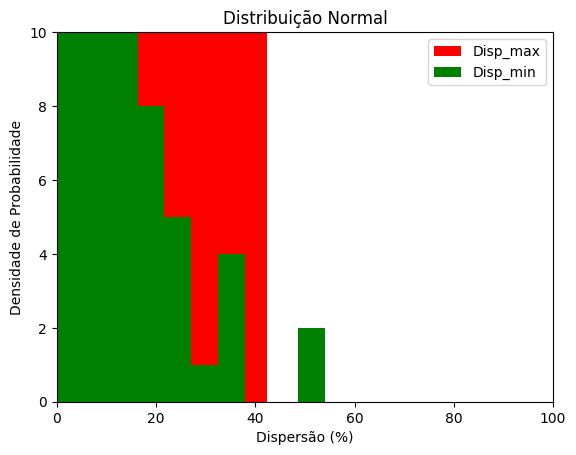

Desvio Padrão Disp_max: 63.77
Desvio Padrão Disp_min: 17.40


In [ ]:
# Converter as colunas 'High' e 'Open' para arrays NumPy
high = np.array(dados['High'])
open_ = np.array(dados['Open'])

# Calcular 'Disp_max' e 'Disp_min'
dados['Disp_max'] = high / open_ * 100 - 100
dados['Disp_min'] = open_ / np.array(dados['Low']) * 100 - 100
disp_max = dados['Disp_max']
disp_min = dados['Disp_min']

# Distribuição do Disp_max
plt.hist(disp_max, color='r', label='Disp_max')

# Distribuição do Disp_min
plt.hist(disp_min, color='g', label='Disp_min')

# Personalização do gráfico
plt.title('Distribuição Normal')
plt.xlabel('Dispersão (%)')
plt.ylabel('Densidade de Probabilidade')
plt.legend()

plt.xlim([0, 100])
plt.ylim([0, 10])

# Exibir o gráfico
plt.show()


# Desvio padrão de Disp_max
desvio_max = np.std(disp_max) * 2

# Desvio padrão de Disp_min
desvio_min = np.std(disp_min) * 2

print(f"Desvio Padrão Disp_max: {desvio_max:.2f}")
print(f"Desvio Padrão Disp_min: {desvio_min:.2f}")

In [ ]:
!pip install mplfinance
!pip install pandas_ta
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=99a8cadd0a6ca13abc659bf0df6fc809569974382e2c0d600c8f652c5647628f
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import matplotlib.patches as mpatches
import mplfinance as mpf
import pandas_ta as ta # análise técnica


# Parâmetros
leng = 20
desv = 2.0

# Definindo dataframe com as BB
bb_plot = dados.ta.bbands(length=leng, std= desv)
bb_plot.iloc[:,:3]
bb_plot
# dados['Close'].plot()

# mpf.plot(dados)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
173,26409.007712,38247.5650,50086.122288,61.904894,0.922356
174,27133.218545,39453.8155,51774.412455,62.455794,1.014025
175,28408.658087,40645.0655,52881.472913,60.211036,0.953562
176,28268.598590,42441.7595,56614.920410,66.788753,1.227683


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Adicionando figura com as velas de preço
fig1 = go.Figure(data=[go.Candlestick(x=dados.index,
                open=dados['Open'],
                high=dados['High'],
                low=dados['Low'],
                close=dados['Close'],
                name="plot")])

# Figura com as bandas de bollinger
fig2 = px.line(bb_plot, x=bb_plot.index, y=[f"BBL_{leng}_{desv}",f"BBU_{leng}_{desv}" ,f"BBM_{leng}_{desv}"])

# Unindo as duas figuras
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.update_layout(xaxis_rangeslider_visible=False)

# adicionando elementos de layout
fig3.update_layout(
    title = dict(text=f"Cotação {symbol}", font=dict(size=20), automargin=False, yref='paper'),
    xaxis_title= dict(text="<b> Data </b>", font=dict(size=20)),
    yaxis_title= dict(text="<b>Preço (R$) </b>", font=dict(size=20)),
    font_family="Courier New",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black",

    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=15,
            color='black',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=15,
            color='black',
        ),
    )
)

# Mostrando plot Final
fig3.show()

# Plot de volume
fig4 = px.bar(dados, x=dados.index, y='Volume')
fig4.show()

## Analise tecnica 1d, comparação de multiplas criptos
- Classificação?
- Aprenizado não supervisionado?
- Selecionar o que mais vai valorizar?
- Selecionar o que mais vai cair?
- KNN classifier
- yfinance
- Comparativo do preço atual do ativo relativo a maxima historica, PM/PA
- Grafico PMax - PA e PA - PMin



Criar uma lista de ativos e fazer a previsão para o intervalo de 1 dia (Pelo yohoo finance usando o maximo de dados possivel), deve retornar o coeficiente de determinação e o preço, dividir o preço pevisto pelo preço atual e ver quais teram maiores ganhos e perdas, também retonar tamanho da lista de dados

Usar preço maximo ao invez de close? fazer a previsão dos 3 (Close, Low e High)?

In [ ]:
carteira = ['BTC', 'ETH', 'OP', 'WAVES', 'XRP', 'SHIB', 'DOGE', 'FTM',
            'GALA', 'XLM', 'NEAR', 'ADA', 'LINK', 'SOL', 'STX', 'FLOW', 'MATIC',
            'SCRT', 'KAVA', 'INJ', 'AVAX', 'RNDR', 'SAND', 'PENDLE', 'DOT',
            'ROSE', 'DCR', 'FIL', 'VET', 'FET', 'TRX', 'BNB', 'PYTH',
            'FLOKI', 'THETA', 'ALGO', 'LTC', 'IMC', 'RUNE', 'ALPHA', 'NKN', 'TON',
            'AMP', 'REEF', 'METIS', 'ICP', 'ATOM', 'APT', 'HBAR',
            'BONK', 'ORDI', 'MEME', 'STRK', 'PORTAL', 'PIXEL', 'QI',
            'CLV', 'IOTA', 'FOR', 'AXS', 'ACA', 'CELO', 'NMR', 'IQ',
            'CTXC', 'POLYX', 'CELR', 'MDT', 'ZRX', 'DIA', 'POWR', 'FXS',
            'BCH', 'BAT', 'NEO', 'QTUM', 'ONT', 'KNC', 'VTHO', 'HNT', 'MKR',
            'ONE', 'BAND', 'STORJ', 'BUSD', 'EGLD', 'PAXG', 'OXT', 'ZEN', 'AAVE',
            'CRV', 'CTSI', 'YFI', 'MANA', 'EOS', 'ZEC', 'ENJ', 'OMG', 'SUSHI', 'LRC',
            'LPT', 'POLY', 'SLP', 'ANT', 'CHZ', 'OGN', 'TLM', 'SNX', 'AUDIO', 'ENS',
            'REQ', 'FLUX', 'COTI', 'VOXEL', 'RLC', 'BICO', 'BNT', 'SPELL',
            'JASMY', 'GTC', 'TFUEL', 'OCEAN', 'LAZIO', 'SANTOS', 'ALPINE', 'PORTO',
            'REN', 'SKL', 'VITE', 'WAXP', 'LTO', 'BOND', 'LOKA', 'KDA', 'KSM', 'ACH',
            'DAR', 'SYS', 'RAD', 'ILV', 'LDO', 'LSK', 'DGB', 'ALICE',
            'FORTH', 'ASTR', 'BTRST', 'GAL', 'BAL', 'GLM', 'QNT',
            'BOSON', 'POND', 'MXC', 'JAM', 'TRAC', 'PROM', 'LOOM', 'STMX', 'IOST',
            'ARB', 'BLUR', 'ANKR', 'DAI', 'DASH', 'ICX', 'RVN', 'XNO', 'XTZ',
            'ZIL', 'ORBS', 'CUDOS', 'ADX', 'PHA']

import requests
import pandas as pd
import numpy as np
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas_ta as ta
import yfinance


# DFA (Análise de Flutuação Detendida)
# MFDFA (Análise de Flutuação com Tendência Multifractal)
# DCCA (Análise de Correlação Cruzada Detendida)
# MFDCCA (Análise de Correlação Cruzada Multifractal Detendida)
# HT (expoente de Hurst dependente do tempo)

# np.set_printoptions(precision=10)

def calculate_rsi(data, window=14):
    # Calcular as variações de preço
    deltas = data['Open'].diff()

    # Separar as variações de preço em positivas e negativas
    gain = deltas.where(deltas > 0, 0)
    loss = -deltas.where(deltas < 0, 0)

    # Calcular as médias móveis
    average_gain = gain.rolling(window=window, min_periods=1).mean()
    average_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calcular o RSI
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


def calculate_rvi(data, window=10):
    close_prices_diff = data['Open'].diff()
    upward_movements = close_prices_diff.where(close_prices_diff > 0, 0).rolling(window=window).mean()
    downward_movements = close_prices_diff.where(close_prices_diff < 0, 0).abs().rolling(window=window).mean()

    # Calcular o RVI
    rvi = (upward_movements / (upward_movements + downward_movements)) * 100

    return rvi


def selectAnaliseTec(dados):
    qtd_data = len(dados)
    train_size = int(0.9 * qtd_data)
    test_size = int(0.1 * qtd_data)
    val_size = qtd_data - train_size - test_size

    #separando as features e labels
    features = dados.drop(['Close', 'High', 'Low', 'Dividends', 'Stock Splits'], axis=1)
    labels = dados[['Close', 'High', 'Low']]

    return qtd_data, train_size, test_size, val_size, features, labels


def hurst_dfa(data):
    # Pré-processamento da série temporal
    data = np.array(data)
    data = data - np.mean(data)
    data = data / np.std(data)
    # print(np.std(data))

    # Cálculo da função de flutuação
    n_windows = len(data) // 2
    ws = np.logspace(np.log10(2), np.log10(n_windows), n_windows)
    F = np.zeros(n_windows)
    for i, w in enumerate(ws):
        n = int(w)
        profile = np.cumsum(data[:n]) - np.mean(data[:n]) * np.arange(n)
        F[i] = np.sqrt(np.mean((profile**2)[1:]))

    # Ajuste da função de flutuação
    H, H_intercept = np.polyfit(np.log10(ws), np.log10(F), 1)

    return H, H_intercept


def identify_fractals(data):
    is_fractals = pd.Series(0, index=data.index, name='Fractal')

    for i in range(2, len(data) - 2):
        prev_high = data['High'].iloc[i-1]
        next_high = data['High'].iloc[i+1]
        next_next_high = data['High'].iloc[i+2]
        prev_low = data['Low'].iloc[i-1]
        next_low = data['Low'].iloc[i+1]
        next_next_low = data['Low'].iloc[i+2]
        prev_close = data['Close'].iloc[i-1]
        curr_high = data['High'].iloc[i]
        curr_low = data['Low'].iloc[i]
        curr_close = data['Close'].iloc[i]

        # Fractal de Alta
        if (curr_high > prev_high and curr_high > next_high and curr_high > next_next_high and
            curr_high == data['High'].iloc[i-2:i+1].max() and curr_close < prev_close):
            is_fractals[i] = 1

        # Fractal de Baixa
        elif (curr_low < prev_low and curr_low < next_low and curr_low < next_next_low and
              curr_low == data['Low'].iloc[i-2:i+1].min() and curr_close > prev_close):
            is_fractals[i] = -1

    data = data.join(is_fractals)
    return data

cripyto = []
pred_close = []
pred_high = []
pred_low = []
PO = []
coef_det = []
PH_PC = []
PC_PL = []
PC_PO = []
PH_PL = []
len_data = []

for ativo in carteira:
    symbol = ativo + '-USD'
    ticker = yfinance.Ticker(symbol)
    dados = ticker.history(period='max', interval='1d')
    # print(len(dados), symbol)
    dados['mm9d'] = dados['Close'].rolling(9).mean()
    dados['mm14d'] = dados['Close'].rolling(14).mean()
    dados['mm21d'] = dados['Close'].rolling(21).mean()
    dados['mm12d'] = dados['Close'].rolling(12).mean()
    dados['mm26d'] = dados['Close'].rolling(26).mean()
    dados['MACD_linha'] = dados['mm12d'] - dados['mm26d']
    dados['MACD_media'] = dados['MACD_linha'].rolling(9).mean()
    dados['MACD_hist'] = dados['MACD_linha'] - dados['MACD_media']
    dados['RSI'] = calculate_rsi(dados)
    dados['RVI'] = calculate_rvi(dados)
    dados['mme17d'] = dados['Close'].ewm(span=17, adjust=False).mean()
    dados['est_RSI'] = (dados['RSI'] - dados['RSI'].rolling(14).min()) / (dados['RSI'].rolling(14).max() - dados['RSI'].rolling(14).min())
    dados['est_RSI_D'] = dados['est_RSI'].rolling(3).mean()
    bb_plot = dados.ta.bbands(close='Open', length=20, std=2)
    dados = pd.concat([dados, bb_plot], axis=1)
    dados['FRAC'] = identify_fractals(dados.loc[:,['Open', 'High', 'Low', 'Close']])['Fractal']
    if dados['Close'].mean() < 0.01:
        dados['LogReturn'] = np.log1p(dados['Close'] / dados['Close'].shift(1))
    else:
        dados['LogReturn'] = np.log(dados['Close'] / dados['Close'].shift(1))
    dados['EWMA_LogReturn'] = dados['LogReturn'].ewm(span=14, adjust=False).mean()
    dados['Volatility'] = dados['LogReturn'].rolling(14).std()

    # dados.to_csv(f'{symbol}-{interval}.csv', index=False)

    if len(dados) > 1000:
        dados['mm55d'] = dados['Close'].rolling(55).mean()
        dados['mme55d'] = dados['Close'].ewm(span=55, adjust=False).mean()
        dados['mm111d'] = dados['Close'].rolling(111).mean()
        dados['mm350d'] = dados['Close'].rolling(350).mean()*2
        dados['mme200d'] = dados['Close'].ewm(span=200, adjust=False).mean()
        H_list = []
        H_intercept_list = []
        for i in range(0, len(dados) - 100):
            if i < 100:
                H_list.append(None)
                H_intercept_list.append(None)

            tam = i + 100
            H, H_intercept = hurst_dfa(dados['Open'][i:tam])

            H_list.append(H)
            H_intercept_list.append(H_intercept)

        dados.insert(27, "H", H_list)
        dados.insert(28, "H_intercept", H_intercept_list)

        dados['Close'] = dados['Close'].shift(-1)
        dados.dropna(inplace=True)
        # display(dados)
        qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(dados)

        features = dados.loc[:,['Open', 'mm9d', 'mm14d', 'mm21d', 'mm55d', 'mm12d',
                                'mm26d', 'MACD_linha', 'MACD_media', 'MACD_hist',
                                'RVI', 'RSI', 'mm111d', 'mm350d', 'mme17d', 'mme55d',
                                'mme200d', 'H', 'H_intercept', 'est_RSI', 'est_RSI_D',
                                'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0',
                                'BBP_20_2.0', 'FRAC', 'LogReturn', 'EWMA_LogReturn',
                                'Volatility', 'Volume']]
    elif len(dados) > 500:
        dados['mm55d'] = dados['Close'].rolling(55).mean()
        dados['mme55d'] = dados['Close'].ewm(span=55, adjust=False).mean()
        dados['mm111d'] = dados['Close'].rolling(111).mean()
        H_list = []
        H_intercept_list = []
        for i in range(0, len(dados) - 100):
            if i < 100:
                H_list.append(None)
                H_intercept_list.append(None)

            tam = i + 100
            H, H_intercept = hurst_dfa(dados['Open'][i:tam])

            H_list.append(H)
            H_intercept_list.append(H_intercept)

        dados.insert(27, "H", H_list)
        dados.insert(28, "H_intercept", H_intercept_list)

        dados['Close'] = dados['Close'].shift(-1)
        dados.dropna(inplace=True)
        # display(dados)
        qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(dados)
        train_size = int(0.75 * qtd_data)
        test_size = int(0.25 * qtd_data)

        features = dados.loc[:,['Open', 'mm9d', 'mm14d', 'mm21d', 'mm55d', 'mm12d',
                                'mm26d', 'MACD_linha', 'MACD_media', 'MACD_hist',
                                'RVI', 'RSI', 'mm111d', 'mme17d', 'mme55d',
                                'H', 'H_intercept', 'est_RSI', 'est_RSI_D',
                                'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0',
                                'BBP_20_2.0', 'FRAC', 'LogReturn', 'EWMA_LogReturn',
                                'Volatility', 'Volume']]
    else:
        dados['Close'] = dados['Close'].shift(-1)
        dados.dropna(inplace=True)
        # display(dados)
        qtd_data, train_size, test_size, val_size, features, labels = selectAnaliseTec(dados)
        train_size = int(0.65 * qtd_data)
        test_size = int(0.35 * qtd_data)
        features = dados.loc[:,['Open', 'mm9d', 'mm14d', 'mm21d', 'mm12d', 'mm26d',
                                'MACD_linha', 'MACD_media', 'MACD_hist', 'RVI',
                                'RSI', 'mme17d', 'est_RSI', 'est_RSI_D', 'BBL_20_2.0',
                                'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0',
                                'FRAC', 'LogReturn', 'EWMA_LogReturn', 'Volatility',
                                'Volume']]

    #Separa os dados de treino teste e validação
    X_train = features[:train_size]
    X_test = features[train_size:train_size + test_size -1]

    y_train = labels[:train_size]
    y_test = labels[train_size:train_size + test_size -1]

    # Normalizando os dados de entrada(features)

    # Gerando o novo padrão
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
    X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

    # treinamento usando regressão linear
    lr = linear_model.LinearRegression()
    lr.fit(X_train_scale, y_train)
    pred = lr.predict(X_test_scale)
    cd_close = r2_score(y_test, pred)

    # print(f'Coeficiente de determinação:{cd_close * 100:.2f}')

    valor_novo = features.tail(1)

    #executando a previsão

    previsao = scaler.transform(valor_novo)


    pred_final = lr.predict(previsao)
    # print(pred_final)
    # print(f'Prev_close: {pred_close:.2f}')

    cripyto.append(symbol)
    pred_close.append(pred_final[0][0])
    pred_high.append(pred_final[0][1])
    pred_low.append(pred_final[0][2])
    coef_det.append(f'{cd_close*100:.2f}')
    PH_PC.append(f'{(pred_final[0][1] / pred_final[0][0]):.2f}')
    PC_PL.append(f'{(pred_final[0][0] / pred_final[0][2]):.2f}')
    PC_PO.append(f'{(pred_final[0][0] / dados['Close'].tail(1).values[0]):.2f}')
    PH_PL.append(f'{(pred_final[0][1] / pred_final[0][2]):.2f}')
    len_data.append(len(dados))
    PO.append(dados['Close'].tail(1).values[0])

dados_finais = pd.DataFrame({
    'Cripto': cripyto,
    'Preço de Fechamento': pred_close,
    'Preço Abertura': PO,
    'Preço Maximo': pred_high,
    'Preço Minimo': pred_low,
    'Coeficiente de Determinação': coef_det,
    'Preço Maximo / Preço de Fechamento': PH_PC,
    'Preço de Fechamento / Preço Minimo': PC_PL,
    'Preço Maximo / Preço Minimo': PH_PL,
    'Preço Fechamento / Preço Abertura': PC_PO,
    'Quant. de Dados': len_data
})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(dados_finais)

,Cripto,Preço de Fechamento,Preço Abertura,Preço Maximo,Preço Minimo,Coeficiente de Determinação,Preço Maximo / Preço de Fechamento,Preço de Fechamento / Preço Minimo,Preço Maximo / Preço Minimo,Quant. de Dados
0,BTC-USD,71644.682031,68434.734375,74323.300625,69664.799106,99.56,1.04,1.03,1.07,3118
1,ETH-USD,3889.957338,3743.606934,4079.207622,3801.882030,99.49,1.05,1.02,1.07,1969
2,OP-USD,4.311650,3.901312,4.541134,4.197860,98.18,1.05,1.03,1.08,577
3,WAVES-USD,4.464264,4.396156,5.146533,3.820038,96.32,1.15,1.17,1.35,1969
4,XRP-USD,0.675402,0.635309,0.707825,0.652301,95.91,1.05,1.04,1.09,1969
5,SHIB-USD,0.000031,0.000030,0.000034,0.000030,97.12,1.08,1.05,1.13,642
6,DOGE-USD,0.172929,0.167149,0.192956,0.156569,98.21,1.12,1.10,1.23,1969
7,FTM-USD,0.857049,0.790151,0.919885,0.814691,98.17,1.07,1.05,1.13,1614
8,GALA-USD,0.079132,0.064870,0.076605,0.068988,87.74,0.97,1.15,1.11,891
9,XLM-USD,0.142797,0.136353,0.150702,0.143514,90.56,1.06,1.00,1.05,1969


Ideia para bot de trade: Ao invez de colocar stop se um preço atingir determinado valor, colocar caso ele feche abaixo do valor de stop durante n candles, variaveis importantes: Numero de candles que devem fechar abaixo, intervalo dos candes e Porcentagem de stop loss

In [ ]:
dados_finais.loc[dados_finais['Coeficiente de Determinação'].astype(float) > 96]

,Cripto,Preço de Fechamento,Preço Abertura,Preço Maximo,Preço Minimo,Coeficiente de Determinação,Preço Maximo / Preço de Fechamento,Preço de Fechamento / Preço Minimo,Preço Maximo / Preço Minimo,Quant. de Dados
0,BTC-USD,71644.682031,68434.734375,74323.300625,69664.799106,99.56,1.04,1.03,1.07,3118
1,ETH-USD,3889.957338,3743.606934,4079.207622,3801.882030,99.49,1.05,1.02,1.07,1969
2,OP-USD,4.311650,3.901312,4.541134,4.197860,98.18,1.05,1.03,1.08,577
3,WAVES-USD,4.464264,4.396156,5.146533,3.820038,96.32,1.15,1.17,1.35,1969
5,SHIB-USD,0.000031,0.000030,0.000034,0.000030,97.12,1.08,1.05,1.13,642
6,DOGE-USD,0.172929,0.167149,0.192956,0.156569,98.21,1.12,1.10,1.23,1969
7,FTM-USD,0.857049,0.790151,0.919885,0.814691,98.17,1.07,1.05,1.13,1614
11,ADA-USD,0.747735,0.721581,0.782351,0.727238,98.96,1.05,1.03,1.08,1969
12,LINK-USD,20.828297,19.544930,21.749278,19.918685,99.09,1.04,1.05,1.09,1969
13,SOL-USD,175.954158,177.716492,183.913308,152.333494,96.68,1.05,1.16,1.21,1086


In [ ]:
features

[[ 0.13698624  0.13170221  0.12173575  0.10677098  0.05674945  0.12278385
   0.09708841  0.7367744   0.78166363  0.51733759  0.7329393   0.71254986
   0.03891558 -0.01228645  0.11629934  0.07144709  0.02271461  0.1872865
   0.71826585  0.3907911   0.40752283  0.17480532  0.10392841  0.12764604
   0.23009294  0.67583207  0.5         0.35359222  0.41735603  0.18471215]]


In [ ]:
import requests

response = requests.get("https://api.binance.us/api/v3/exchangeInfo")

if response.status_code == 200:
    data = response.json()

    for item in data["symbols"]:
        if item["symbol"].endswith("USDT"):
            cripyto = item["symbol"][:-4]
            if cripyto not in carteira:
                print(cripyto)
else:
    print('ERROR')

ETC
1INCH
USDC
UST
API3
T
TUSD
FLOKI8


In [ ]:
len(carteira)

192

In [10]:
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Usando shift(-i)

In [7]:
import requests
import pandas as pd
import numpy as np
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas_ta as ta
import yfinance
plt.style.use('default')


# DFA (Análise de Flutuação Detendida)
# MFDFA (Análise de Flutuação com Tendência Multifractal)
# DCCA (Análise de Correlação Cruzada Detendida)
# MFDCCA (Análise de Correlação Cruzada Multifractal Detendida)
# HT (expoente de Hurst dependente do tempo)

# np.set_printoptions(precision=10)

def calculate_rsi(data, window=14):
    # Calcular as variações de preço
    deltas = data['Open'].diff()

    # Separar as variações de preço em positivas e negativas
    gain = deltas.where(deltas > 0, 0)
    loss = -deltas.where(deltas < 0, 0)

    # Calcular as médias móveis
    average_gain = gain.rolling(window=window, min_periods=1).mean()
    average_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calcular o RSI
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


def calculate_rvi(data, window=10):
    close_prices_diff = data['Open'].diff()
    upward_movements = close_prices_diff.where(close_prices_diff > 0, 0).rolling(window=window).mean()
    downward_movements = close_prices_diff.where(close_prices_diff < 0, 0).abs().rolling(window=window).mean()

    # Calcular o RVI
    rvi = (upward_movements / (upward_movements + downward_movements)) * 100

    return rvi


def selectAnaliseTec(dados):
    qtd_data = len(dados)
    train_size = int(0.9 * qtd_data)
    test_size = int(0.1 * qtd_data)

    val_size = qtd_data - train_size - test_size

    #separando as features e labels
    features = dados.drop(['Close', 'High', 'Low', 'Dividends', 'Stock Splits'], axis=1)
    labels1 = dados['Close']
    labels2 = dados['High']
    labels3 = dados['Low']

    return qtd_data, train_size, test_size, val_size, features, labels1, labels2, labels3


def hurst_dfa(data):
    # Pré-processamento da série temporal
    data = np.array(data)
    data = data - np.mean(data)
    data = data / np.std(data)
    # print(np.std(data))

    # Cálculo da função de flutuação
    n_windows = len(data) // 2
    ws = np.logspace(np.log10(2), np.log10(n_windows), n_windows)
    F = np.zeros(n_windows)
    for i, w in enumerate(ws):
        n = int(w)
        profile = np.cumsum(data[:n]) - np.mean(data[:n]) * np.arange(n)
        F[i] = np.sqrt(np.mean((profile**2)[1:]))

    # Ajuste da função de flutuação
    H, H_intercept = np.polyfit(np.log10(ws), np.log10(F), 1)

    return H, H_intercept


def identify_fractals(data):
    is_fractals = pd.Series(0, index=data.index, name='Fractal')

    for i in range(2, len(data) - 2):
        prev_high = data['High'].iloc[i-1]
        next_high = data['High'].iloc[i+1]
        next_next_high = data['High'].iloc[i+2]
        prev_low = data['Low'].iloc[i-1]
        next_low = data['Low'].iloc[i+1]
        next_next_low = data['Low'].iloc[i+2]
        prev_close = data['Close'].iloc[i-1]
        curr_high = data['High'].iloc[i]
        curr_low = data['Low'].iloc[i]
        curr_close = data['Close'].iloc[i]

        # Fractal de Alta
        if (curr_high > prev_high and curr_high > next_high and curr_high > next_next_high and
            curr_high == data['High'].iloc[i-2:i+1].max() and curr_close < prev_close):
            is_fractals.iloc[i] = 1

        # Fractal de Baixa
        elif (curr_low < prev_low and curr_low < next_low and curr_low < next_next_low and
              curr_low == data['Low'].iloc[i-2:i+1].min() and curr_close > prev_close):
            is_fractals.iloc[i] = -1

    data = data.join(is_fractals)
    return data

v_open = []
pred_close = []
pred_high = []
pred_low = []
coef_det_c = []
coef_det_h = []
coef_det_l = []
cont = 0

# Sem correlação entre os dados
# UNI

# Dados Insuficientes
# PYTH, SEI, GRT, WIF, PEPE

periodo = 2
n = 0

if periodo == 0:
    preds = 25
elif periodo == 1:
    preds = 8
elif periodo == 2:
    preds = 169
elif periodo == 3:
    preds = 61
elif periodo == 4:
    preds = 49
elif periodo == 5:
    preds = 31

ativos = ['BTC', 'ETH', 'MATIC', 'INJ', 'NEAR', 'MANA', 'RNDR', 'ADA', 'LINK',
          'FET', 'GALA', 'VET', 'MKR', 'FIL', 'SOL', 'DOT', 'AGIX', 'AVAX',
          'PENDLE', 'THETA', 'SHIB', 'TON', 'OP', 'BNB', 'ICP']

for i in range(1, preds+1):

    symbol = f'{ativos[n]}-USD'
    ticker = yfinance.Ticker(symbol)
    btc = yfinance.Ticker('BTC-USD')
    if periodo == 1 or periodo == 3 or periodo == 5:
        dados = ticker.history(period='max', interval='1d')
        dados_btc = btc.history(period=f'{len(dados)}d', interval='1d')
    elif periodo == 0 or periodo == 2 or periodo == 4:
        dados = ticker.history(period='720d', interval='1h')
        dados_btc = btc.history(period='720d', interval='1h')

    dados = dados.drop(index=dados.index[len(dados) - 1])
    dados_btc = dados_btc.drop(index=dados.index[len(dados) - 1])
    dados['btc'] = dados_btc['Close']
    dados['mm9d'] = dados['Close'].rolling(9).mean()
    dados['mm14d'] = dados['Close'].rolling(14).mean()
    dados['mm21d'] = dados['Close'].rolling(21).mean()
    dados['mm12d'] = dados['Close'].rolling(12).mean()
    dados['mm26d'] = dados['Close'].rolling(26).mean()
    dados['MACD_linha'] = dados['mm12d'] - dados['mm26d']
    dados['MACD_media'] = dados['MACD_linha'].rolling(9).mean()
    dados['MACD_hist'] = dados['MACD_linha'] - dados['MACD_media']
    dados['RSI'] = calculate_rsi(dados)
    dados['RVI'] = calculate_rvi(dados)
    dados['mme17d'] = dados['Close'].ewm(span=17, adjust=False).mean()
    dados['est_RSI'] = (dados['RSI'] - dados['RSI'].rolling(14).min()) / (dados['RSI'].rolling(14).max() - dados['RSI'].rolling(14).min())
    dados['est_RSI_D'] = dados['est_RSI'].rolling(3).mean()
    bb_plot = dados.ta.bbands(close='Open', length=20, std=2)
    dados = pd.concat([dados, bb_plot], axis=1)
    dados['LogReturn'] = np.log(dados['Close'] / dados['Close'].shift(1))
    dados['EWMA_LogReturn'] = dados['LogReturn'].ewm(span=14, adjust=False).mean()
    dados['Volatility'] = dados['LogReturn'].rolling(14).std()

    # dados.to_csv(f'{symbol}-{interval}.csv', index=False)

    dados['mm55d'] = dados['Close'].rolling(55).mean()
    dados['mme55d'] = dados['Close'].ewm(span=55, adjust=False).mean()

    if len(dados) > 1500:
        dados['mm350d'] = dados['Close'].rolling(350).mean()*2
        dados['mme200d'] = dados['Close'].ewm(span=200, adjust=False).mean()
        dados['mm111d'] = dados['Close'].rolling(111).mean()

        dados['FRAC'] = identify_fractals(dados.loc[:,['Open', 'High', 'Low', 'Close']])['Fractal']

        dados['Close'] = dados['Close'].shift(-i)
        dados['High'] = dados['High'].shift(-i)
        dados['Low'] = dados['Low'].shift(-i)

        dur = 30
        H_list = []
        H_intercept_list = []
        for i in range(0, len(dados) - dur):
            if i < dur:
                H_list.append(None)
                H_intercept_list.append(None)

            tam = i + dur
            H, H_intercept = hurst_dfa(dados['Open'][i:tam])

            H_list.append(H)
            H_intercept_list.append(H_intercept)

        dados.insert(27, "H", H_list)
        dados.insert(28, "H_intercept", H_intercept_list)

    else:
        dados['Close'] = dados['Close'].shift(-i)
        dados['High'] = dados['High'].shift(-i)
        dados['Low'] = dados['Low'].shift(-i)


    dados.dropna(inplace=True)
    qtd_data, train_size, test_size, val_size, features, labels1, labels2, labels3 = selectAnaliseTec(dados)

    if len(dados) > 1500:
        features = dados.loc[:,['Open', 'mm9d', 'mm14d', 'mm21d', 'mm55d', 'mm12d',
                            'mm26d', 'MACD_linha', 'MACD_media', 'MACD_hist',
                            'RVI', 'RSI', 'mm111d', 'mm350d', 'mme17d', 'mme55d',
                            'mme200d', 'H', 'H_intercept', 'est_RSI', 'est_RSI_D',
                            'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0',
                            'BBP_20_2.0', 'FRAC', 'LogReturn', 'EWMA_LogReturn',
                            'Volatility', 'Volume']]
    else:
        features = dados.loc[:,['Open', 'mm9d', 'mm14d', 'mm21d', 'mm55d', 'mm12d',
                            'mm26d', 'MACD_linha', 'MACD_media', 'MACD_hist', 'RVI',
                            'RSI', 'mme17d', 'mme55d', 'est_RSI', 'est_RSI_D',
                            'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0',
                            'BBP_20_2.0', 'LogReturn', 'EWMA_LogReturn', 'Volatility',
                            'Volume']]

    #Separa os dados de treino teste e validação
    X_train = features[:train_size]
    X_test = features[train_size:train_size + test_size -1]

    y_train1 = labels1[:train_size]
    y_test1 = labels1[train_size:train_size + test_size -1]

    y_train2 = labels2[:train_size]
    y_test2 = labels2[train_size:train_size + test_size -1]

    y_train3 = labels3[:train_size]
    y_test3 = labels3[train_size:train_size + test_size -1]

    # Normalizando os dados de entrada(features)

    # Gerando o novo padrão
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
    X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

    valor_novo = features.tail(1)
    previsao = scaler.transform(valor_novo)


    # treinamento usando regressão linear close

    lr = linear_model.LinearRegression()
    lr.fit(X_train_scale, y_train1)
    pred = lr.predict(X_test_scale)
    cd_close = r2_score(y_test1, pred)

    #executando a previsão

    pred_final = lr.predict(previsao)
    pred_close.append(pred_final[0])

    # treinamento usando regressão linear high
    lr = linear_model.LinearRegression()
    lr.fit(X_train_scale, y_train2)
    pred = lr.predict(X_test_scale)
    cd_high = r2_score(y_test2, pred)

    #executando a previsão

    pred_final = lr.predict(previsao)
    pred_high.append(pred_final[0])

    # treinamento usando regressão linear low
    lr = linear_model.LinearRegression()
    lr.fit(X_train_scale, y_train3)
    pred = lr.predict(X_test_scale)
    cd_low = r2_score(y_test3, pred)

    #executando a previsão

    pred_final = lr.predict(previsao)
    pred_low.append(pred_final[0])


    coef_det_c.append(f'{cd_close*100:.2f}')
    coef_det_h.append(f'{cd_high*100:.2f}')
    coef_det_l.append(f'{cd_low*100:.2f}')

    if cont == 0:
        v_open.append(dados['Close'].tail(1).values[0])
    else:
        v_open.append(pred_close[cont-1])

    cont += 1

# Plotar os valores
coef_det_c_float = [float(x) for x in coef_det_c]
coef_det_h_float = [float(x) for x in coef_det_h]
coef_det_l_float = [float(x) for x in coef_det_l]

# Criando uma figura com 2 subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotando os valores de previsão no primeiro subplot
axs[0].plot(pred_close, marker='o', linestyle='-', label='PrevS Close')
axs[0].plot(pred_high, marker='s', linestyle='--', label='PrevS High')
axs[0].plot(pred_low, marker='^', linestyle=':', label='PrevS Low')
axs[0].set_xlabel('Índice')
axs[0].set_ylabel('Valores')
axs[0].set_title(f'Gráfico de PrevS {symbol} - 1d')
axs[0].grid(True)
axs[0].legend()

# Plotando 'coef_det' no segundo subplot
axs[1].plot(coef_det_c_float, marker='o', linestyle='-', label='Coeficiente de Determinação Close')
axs[1].plot(coef_det_h_float, marker='s', linestyle='--', label='Coeficiente de Determinação High')
axs[1].plot(coef_det_l_float, marker='^', linestyle=':', label='Coeficiente de Determinação Low')
axs[1].set_xlabel('Índice')
axs[1].set_ylabel('Coeficiente de Determinação (%)')
axs[1].set_title('Coeficiente de Determinação')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()

# Mostrando a figura com os subplots
plt.show()

BTC-USD: No price data found, symbol may be delisted (period=720d)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [6]:
dados.shape

(3146, 37)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.patches as mpatches
import mplfinance as mpf
import pandas_ta as ta # análise técnica


# Listas de dados
data = {
    'Open': v_open,
    'Close': pred_close,
    'High': pred_high,
    'Low': pred_low
}

# Criar DataFrame
df = pd.DataFrame(data)

# Parâmetros
leng = 20
desv = 2.0

# Definindo dataframe com as BB
bb_plot = df.ta.bbands(length=leng, std= desv)

# Adicionando figura com as velas de preço
fig1 = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name="plot")])

# Figura com as bandas de bollinger
fig2 = px.line(bb_plot, x=bb_plot.index, y=[f"BBL_{leng}_{desv}",f"BBU_{leng}_{desv}" ,f"BBM_{leng}_{desv}"])

# Unindo as duas figuras
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.update_layout(xaxis_rangeslider_visible=False)

# adicionando elementos de layout
fig3.update_layout(
    title = dict(text=f"Cotação {symbol}", font=dict(size=20), automargin=False, yref='paper'),
    xaxis_title= dict(text="<b> Data </b>", font=dict(size=20)),
    yaxis_title= dict(text="<b>Preço (R$) </b>", font=dict(size=20)),
    font_family="Courier New",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black",

    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=15,
            color='black',
        ),
    ),
    yaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=15,
            color='black',
        ),
    )
)

# Mostrando plot Final
fig3.show()

In [ ]:
# modulo python binance, websocket?
# kucoin: https://youtu.be/pDYonsJkjA8?si=tG8ZxSuk467Oky-3
# binance: https://www.binance.com/en/trading-bots
# Tentar prever o ajuste do preço, dados['Close'] / dados['Close'].shfit(1)